In [1]:
%reset
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow_datasets as tfds

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
# 이미지의 표현이 0과 1 사이로 들어오도록 정규화
def normalize_and_resize_img(image, label):
    image = tf.image.resize(image, (224,224))
    return tf.cast(image, tf.float32) / 255., label

In [3]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [4]:
# function for building Resnet Block
def build_resnet_block(input_layer, num_cnn=3, channel=64, block_num=1, is_50=False, is_plain = False):
    # is_plain : skip connection 사용 여부 결정
    
    # 입력 레이어
    x = input_layer

    # CNN 레이어 : 3, 4, 6, 3개
    if is_50 :
        identity = x
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(1,1),
            activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_conv{cnn_num}'
        )(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(3,3),
            activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_1_conv{cnn_num}'
        )(x)
        x = keras.layers.Conv2D(
            filters=channel * 4,
            kernel_size=(1,1),
            activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_2_conv{cnn_num}'
        )(x)
        if not is_plain:
            identity_channel = identity.shape.as_list()[-1]    

            if identity_channel != channel:
                identity = keras.layers.Conv2D(channel, kernel_size=(1, 1), strides=(1, 1), padding="same")(identity)  
            # skip connection
            x = keras.layers.Add()([x,identity])   
        else:
            pass
    else: # 50이 아닐 때
        for cnn_num in range(num_cnn):
            identity = x
            x = keras.layers.Conv2D(
                filters=channel,
                kernel_size=(3,3),
                activation='relu',
                kernel_initializer='he_normal',
                padding='same',
                name=f'block{block_num}_conv{cnn_num}'
            )(x)
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Conv2D(
                filters=channel,
                kernel_size=(3,3),
                activation='relu',
                kernel_initializer='he_normal',
                padding='same',
                name=f'block{block_num}_1_conv{cnn_num}'
            )(x)
            if not is_plain:
                identity_channel = identity.shape.as_list()[-1]    

                if identity_channel != channel:
                    identity = keras.layers.Conv2D(channel, kernel_size=(1, 1), strides=(1, 1), padding="same")(identity)  
                # skip connection
                x = keras.layers.Add()([x,identity])   
            else:
                pass

    # Max Pooling 레이어
    if identity.shape[1] != 1:        
        x = keras.layers.MaxPooling2D(
            pool_size=(2, 2),
            strides=2,
            name=f'block{block_num}_pooling'
        )(x)

    return x

In [5]:
# ResNet 모델 자체를 생성하는 함수
def build_resnet(input_shape=(224,224,3),
              num_cnn_list=[3,4,6,3],
              channel_list=[64,128,256,512],
              num_classes=10,is_50 = False, is_plain = False):
    
    assert len(num_cnn_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    if is_50:
        num_cnn_list = [3,4,6,3]
        channel_list = [64,128,256,512]
        num_classes = 10
        
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    output = input_layer
    #conv1층
    output = keras.layers.Conv2D(filters=64,
                       kernel_size = (2,2),
                       strides = 2,
                         padding = 'valid')(output)
    output = keras.layers.BatchNormalization()(output)
    
    #conv2_x pooling
    output = keras.layers.MaxPooling2D(pool_size = (2,2),
                                      strides = 2,)(output)    
    # config list들의 길이만큼 반복해서 블록을 생성합니다.
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_resnet_block(
            output,
            num_cnn=num_cnn, 
            channel=channel,
            block_num=i
        )    
    output = keras.layers.AveragePooling2D(padding = 'same')(output)
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(512, activation='relu', name='fc1')(output)    
    output = keras.layers.Dense(num_classes, activation='softmax', name='predictions')(output)
    
    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )
    return model

In [6]:
# 모델 선언
resnet_34 = build_resnet(is_50 = False, is_plain = True)
resnet_50 = build_resnet(is_50 = True, is_plain = True)

resnet_34.summary()
resnet_50.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 64) 832         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 112, 112, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 56, 56, 64)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [7]:
BATCH_SIZE = 32
EPOCH = 30

In [8]:
# dataset
setattr(tfds.image_classification.cats_vs_dogs, '_URL',"https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip")
ds_train, ds_info = tfds.load(
    'cats_vs_dogs', split='train',
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
# train test split
DATASET_SIZE = ds_train.cardinality().numpy()

train_size = int(0.7 * DATASET_SIZE)
test_size  = int(0.3 * DATASET_SIZE)

ds_train = ds_train.skip(train_size)
ds_test = ds_train.take(test_size)

ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True, batch_size=BATCH_SIZE)

In [9]:
resnet_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

# steps_per_epoch : 한 에폭 훈련에 사용할 배치 개수
# validation_steps : 한 에폭 끝난 뒤 테스트에 사용되는 배치 개수
history_34 = resnet_34.fit(
    ds_train,
    steps_per_epoch=int(train_size/BATCH_SIZE),
    validation_steps=int(test_size/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/30


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


 20/508 [>.............................] - ETA: 1:09 - loss: 3.5137 - accuracy: 0.4781

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


 53/508 [==>...........................] - ETA: 2:06 - loss: 2.4795 - accuracy: 0.5171

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


151/508 [=======>......................] - ETA: 1:07 - loss: 1.9187 - accuracy: 0.5490

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


172/508 [=========>....................] - ETA: 1:01 - loss: 1.8498 - accuracy: 0.5558

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


183/508 [=========>....................] - ETA: 59s - loss: 1.8212 - accuracy: 0.5582

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


219/508 [===========>..................] - ETA: 50s - loss: 1.7437 - accuracy: 0.5635

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


228/508 [============>.................] - ETA: 48s - loss: 1.7305 - accuracy: 0.5650

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


239/508 [=============>................] - ETA: 46s - loss: 1.7016 - accuracy: 0.5697

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


268/508 [==============>...............] - ETA: 47s - loss: 1.6499 - accuracy: 0.5768

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


370/508 [====================>.........] - ETA: 25s - loss: 1.5090 - accuracy: 0.5895

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


387/508 [=====================>........] - ETA: 21s - loss: 1.4885 - accuracy: 0.5920

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


401/508 [======================>.......] - ETA: 19s - loss: 1.4704 - accuracy: 0.5938

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


437/508 [========================>.....] - ETA: 12s - loss: 1.4332 - accuracy: 0.5967

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


445/508 [=========================>....] - ETA: 11s - loss: 1.4253 - accuracy: 0.5977

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


458/508 [==========================>...] - ETA: 8s - loss: 1.4124 - accuracy: 0.5986

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


481/508 [===========================>..] - ETA: 5s - loss: 1.3927 - accuracy: 0.6004

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


508/508 [==============================] - ETA: 0s - loss: 1.3708 - accuracy: 0.6017

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


508/508 [==============================] - 169s 219ms/step - loss: 1.3708 - accuracy: 0.6017 - val_loss: 0.8579 - val_accuracy: 0.5986
Epoch 2/30
 79/508 [===>..........................] - ETA: 1:01 - loss: 0.9026 - accuracy: 0.6392

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 93/508 [====>.........................] - ETA: 59s - loss: 0.9035 - accuracy: 0.6364

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


107/508 [=====>........................] - ETA: 57s - loss: 0.8852 - accuracy: 0.6399

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


144/508 [=======>......................] - ETA: 52s - loss: 0.8566 - accuracy: 0.6480

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


152/508 [=======>......................] - ETA: 51s - loss: 0.8637 - accuracy: 0.6458

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


169/508 [========>.....................] - ETA: 48s - loss: 0.8513 - accuracy: 0.6492

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


183/508 [=========>....................] - ETA: 1:04 - loss: 0.8468 - accuracy: 0.6506

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


289/508 [================>.............] - ETA: 38s - loss: 0.8110 - accuracy: 0.6594

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


304/508 [================>.............] - ETA: 35s - loss: 0.8098 - accuracy: 0.6596

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


321/508 [=================>............] - ETA: 32s - loss: 0.8095 - accuracy: 0.6589

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


358/508 [====================>.........] - ETA: 25s - loss: 0.7913 - accuracy: 0.6634

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


366/508 [====================>.........] - ETA: 24s - loss: 0.7892 - accuracy: 0.6635

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


388/508 [=====================>........] - ETA: 20s - loss: 0.7816 - accuracy: 0.6659

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


412/508 [=======================>......] - ETA: 17s - loss: 0.7711 - accuracy: 0.6697

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


439/508 [========================>.....] - ETA: 12s - loss: 0.7647 - accuracy: 0.6714

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


478/508 [===========================>..] - ETA: 5s - loss: 0.7594 - accuracy: 0.6713

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


508/508 [==============================] - ETA: 0s - loss: 0.7511 - accuracy: 0.6737

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


508/508 [==============================] - 108s 214ms/step - loss: 0.7511 - accuracy: 0.6737 - val_loss: 0.6538 - val_accuracy: 0.6747
Epoch 3/30
 32/508 [>.............................] - ETA: 1:08 - loss: 0.6201 - accuracy: 0.7158

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 54/508 [==>...........................] - ETA: 1:04 - loss: 0.6099 - accuracy: 0.7170

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 58/508 [==>...........................] - ETA: 1:04 - loss: 0.6055 - accuracy: 0.7166

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


 95/508 [====>.........................] - ETA: 59s - loss: 0.5850 - accuracy: 0.7237

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 99/508 [====>.........................] - ETA: 59s - loss: 0.5784 - accuracy: 0.7270

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


107/508 [=====>........................] - ETA: 1:11 - loss: 0.5733 - accuracy: 0.7290

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


169/508 [========>.....................] - ETA: 56s - loss: 0.5690 - accuracy: 0.7371

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


187/508 [==========>...................] - ETA: 52s - loss: 0.5794 - accuracy: 0.7305

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


201/508 [==========>...................] - ETA: 49s - loss: 0.5757 - accuracy: 0.7314

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


238/508 [=============>................] - ETA: 42s - loss: 0.5690 - accuracy: 0.7352

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


246/508 [=============>................] - ETA: 41s - loss: 0.5674 - accuracy: 0.7352

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


282/508 [===============>..............] - ETA: 35s - loss: 0.5627 - accuracy: 0.7376

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


286/508 [===============>..............] - ETA: 34s - loss: 0.5620 - accuracy: 0.7381

288/508 [================>.............] - ETA: 34s - loss: 0.5614 - accuracy: 0.7378

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


293/508 [================>.............] - ETA: 33s - loss: 0.5632 - accuracy: 0.7372

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


299/508 [================>.............] - ETA: 32s - loss: 0.5631 - accuracy: 0.7372

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


301/508 [================>.............] - ETA: 32s - loss: 0.5624 - accuracy: 0.7374

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


323/508 [==================>...........] - ETA: 28s - loss: 0.5571 - accuracy: 0.7407

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


389/508 [=====================>........] - ETA: 18s - loss: 0.5523 - accuracy: 0.7436

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


405/508 [======================>.......] - ETA: 15s - loss: 0.5487 - accuracy: 0.7447

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


422/508 [=======================>......] - ETA: 13s - loss: 0.5462 - accuracy: 0.7459

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


458/508 [==========================>...] - ETA: 7s - loss: 0.5422 - accuracy: 0.7474

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


466/508 [==========================>...] - ETA: 6s - loss: 0.5419 - accuracy: 0.7475

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


501/508 [============================>.] - ETA: 1s - loss: 0.5369 - accuracy: 0.7491

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


505/508 [============================>.] - ETA: 0s - loss: 0.5354 - accuracy: 0.7499

507/508 [============================>.] - ETA: 0s - loss: 0.5352 - accuracy: 0.7498

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


508/508 [==============================] - ETA: 0s - loss: 0.5350 - accuracy: 0.7498

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0

508/508 [==============================] - 99s 195ms/step - loss: 0.5350 - accuracy: 0.7498 - val_loss: 0.4470 - val_accuracy: 0.8023
Epoch 4/30
102/508 [=====>........................] - ETA: 57s - loss: 0.4456 - accuracy: 0.7910

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


116/508 [=====>........................] - ETA: 55s - loss: 0.4526 - accuracy: 0.7912

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


130/508 [======>.......................] - ETA: 53s - loss: 0.4462 - accuracy: 0.7942

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


167/508 [========>.....................] - ETA: 48s - loss: 0.4497 - accuracy: 0.7923

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


175/508 [=========>....................] - ETA: 47s - loss: 0.4504 - accuracy: 0.7920

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


214/508 [===========>..................] - ETA: 42s - loss: 0.4437 - accuracy: 0.7950

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


217/508 [===========>..................] - ETA: 42s - loss: 0.4433 - accuracy: 0.7951

219/508 [===========>..................] - ETA: 41s - loss: 0.4425 - accuracy: 0.7955

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


224/508 [============>.................] - ETA: 41s - loss: 0.4411 - accuracy: 0.7963

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


228/508 [============>.................] - ETA: 40s - loss: 0.4407 - accuracy: 0.7963

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


229/508 [============>.................] - ETA: 40s - loss: 0.4401 - accuracy: 0.7964

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


254/508 [==============>...............] - ETA: 36s - loss: 0.4408 - accuracy: 0.7968

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


270/508 [==============>...............] - ETA: 34s - loss: 0.4334 - accuracy: 0.8008

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


338/508 [==================>...........] - ETA: 24s - loss: 0.4247 - accuracy: 0.8059

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


375/508 [=====================>........] - ETA: 19s - loss: 0.4210 - accuracy: 0.8081

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


396/508 [======================>.......] - ETA: 16s - loss: 0.4196 - accuracy: 0.8093

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


398/508 [======================>.......] - ETA: 15s - loss: 0.4212 - accuracy: 0.8087

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


431/508 [========================>.....] - ETA: 11s - loss: 0.4167 - accuracy: 0.8112

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


435/508 [========================>.....] - ETA: 10s - loss: 0.4172 - accuracy: 0.8111

437/508 [========================>.....] - ETA: 10s - loss: 0.4168 - accuracy: 0.8114

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


442/508 [=========================>....] - ETA: 9s - loss: 0.4162 - accuracy: 0.8115

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


448/508 [=========================>....] - ETA: 8s - loss: 0.4161 - accuracy: 0.8114

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


450/508 [=========================>....] - ETA: 8s - loss: 0.4162 - accuracy: 0.8116

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


474/508 [==========================>...] - ETA: 4s - loss: 0.4141 - accuracy: 0.8120

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


508/508 [==============================] - ETA: 0s - loss: 0.4089 - accuracy: 0.8151

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


508/508 [==============================] - 92s 181ms/step - loss: 0.4089 - accuracy: 0.8151 - val_loss: 0.3315 - val_accuracy: 0.8539
Epoch 5/30
 30/508 [>.............................] - ETA: 1:07 - loss: 0.3715 - accuracy: 0.8260

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 46/508 [=>............................] - ETA: 1:05 - loss: 0.3615 - accuracy: 0.8342

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 62/508 [==>...........................] - ETA: 1:03 - loss: 0.3635 - accuracy: 0.8352

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 99/508 [====>.........................] - ETA: 58s - loss: 0.3592 - accuracy: 0.8406

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


107/508 [=====>........................] - ETA: 57s - loss: 0.3609 - accuracy: 0.8397

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


143/508 [=======>......................] - ETA: 52s - loss: 0.3556 - accuracy: 0.8442

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


144/508 [=======>......................] - ETA: 52s - loss: 0.3562 - accuracy: 0.8442

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


147/508 [=======>......................] - ETA: 52s - loss: 0.3540 - accuracy: 0.8450

154/508 [========>.....................] - ETA: 51s - loss: 0.3515 - accuracy: 0.8456

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


159/508 [========>.....................] - ETA: 50s - loss: 0.3547 - accuracy: 0.8438

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


185/508 [=========>....................] - ETA: 47s - loss: 0.3550 - accuracy: 0.8432

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


234/508 [============>.................] - ETA: 39s - loss: 0.3427 - accuracy: 0.8499

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


256/508 [==============>...............] - ETA: 36s - loss: 0.3427 - accuracy: 0.8508

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


295/508 [================>.............] - ETA: 30s - loss: 0.3372 - accuracy: 0.8536

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


325/508 [==================>...........] - ETA: 26s - loss: 0.3350 - accuracy: 0.8558

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


329/508 [==================>...........] - ETA: 25s - loss: 0.3346 - accuracy: 0.8559

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


360/508 [====================>.........] - ETA: 21s - loss: 0.3330 - accuracy: 0.8560

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


365/508 [====================>.........] - ETA: 20s - loss: 0.3309 - accuracy: 0.8571

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


372/508 [====================>.........] - ETA: 19s - loss: 0.3314 - accuracy: 0.8567

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


378/508 [=====================>........] - ETA: 18s - loss: 0.3320 - accuracy: 0.8567

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


380/508 [=====================>........] - ETA: 18s - loss: 0.3317 - accuracy: 0.8567

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


403/508 [======================>.......] - ETA: 15s - loss: 0.3310 - accuracy: 0.8567

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


470/508 [==========================>...] - ETA: 5s - loss: 0.3216 - accuracy: 0.8612

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


484/508 [===========================>..] - ETA: 3s - loss: 0.3202 - accuracy: 0.8620

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


499/508 [============================>.] - ETA: 1s - loss: 0.3188 - accuracy: 0.8627

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


508/508 [==============================] - ETA: 0s - loss: 0.3190 - accuracy: 0.8627

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


508/508 [==============================] - 93s 183ms/step - loss: 0.3190 - accuracy: 0.8627 - val_loss: 0.4377 - val_accuracy: 0.8076
Epoch 6/30
 27/508 [>.............................] - ETA: 1:08 - loss: 0.2607 - accuracy: 0.9005

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 35/508 [=>............................] - ETA: 1:07 - loss: 0.2589 - accuracy: 0.8973

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


 76/508 [===>..........................] - ETA: 1:02 - loss: 0.2590 - accuracy: 0.8939

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 82/508 [===>..........................] - ETA: 1:01 - loss: 0.2521 - accuracy: 0.8967

 88/508 [====>.........................] - ETA: 1:01 - loss: 0.2499 - accuracy: 0.8977

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


 95/508 [====>.........................] - ETA: 1:00 - loss: 0.2491 - accuracy: 0.8970

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


 98/508 [====>.........................] - ETA: 59s - loss: 0.2499 - accuracy: 0.8967

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


119/508 [======>.......................] - ETA: 58s - loss: 0.2464 - accuracy: 0.8984

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


146/508 [=======>......................] - ETA: 54s - loss: 0.2558 - accuracy: 0.8926

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


148/508 [=======>......................] - ETA: 54s - loss: 0.2551 - accuracy: 0.8932

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


154/508 [========>.....................] - ETA: 53s - loss: 0.2553 - accuracy: 0.8918

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


165/508 [========>.....................] - ETA: 51s - loss: 0.2534 - accuracy: 0.8928

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


171/508 [=========>....................] - ETA: 50s - loss: 0.2522 - accuracy: 0.8935

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


228/508 [============>.................] - ETA: 41s - loss: 0.2468 - accuracy: 0.8945

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


232/508 [============>.................] - ETA: 41s - loss: 0.2473 - accuracy: 0.8940

238/508 [=============>................] - ETA: 40s - loss: 0.2455 - accuracy: 0.8954

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


244/508 [=============>................] - ETA: 39s - loss: 0.2449 - accuracy: 0.8951

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


247/508 [=============>................] - ETA: 38s - loss: 0.2441 - accuracy: 0.8954

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


269/508 [==============>...............] - ETA: 35s - loss: 0.2430 - accuracy: 0.8954

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


313/508 [=================>............] - ETA: 28s - loss: 0.2366 - accuracy: 0.8982

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


339/508 [===================>..........] - ETA: 24s - loss: 0.2372 - accuracy: 0.8987

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


391/508 [======================>.......] - ETA: 17s - loss: 0.2352 - accuracy: 0.8997

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


413/508 [=======================>......] - ETA: 13s - loss: 0.2345 - accuracy: 0.9004

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


415/508 [=======================>......] - ETA: 13s - loss: 0.2350 - accuracy: 0.9005

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


443/508 [=========================>....] - ETA: 9s - loss: 0.2311 - accuracy: 0.9017

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


449/508 [=========================>....] - ETA: 8s - loss: 0.2326 - accuracy: 0.9012

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


452/508 [=========================>....] - ETA: 8s - loss: 0.2326 - accuracy: 0.9013

459/508 [==========================>...] - ETA: 7s - loss: 0.2318 - accuracy: 0.9019

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


461/508 [==========================>...] - ETA: 6s - loss: 0.2314 - accuracy: 0.9022

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


466/508 [==========================>...] - ETA: 6s - loss: 0.2309 - accuracy: 0.9026

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


494/508 [============================>.] - ETA: 2s - loss: 0.2320 - accuracy: 0.9027

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


508/508 [==============================] - ETA: 0s - loss: 0.2305 - accuracy: 0.9035

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


508/508 [==============================] - 97s 190ms/step - loss: 0.2305 - accuracy: 0.9035 - val_loss: 0.3663 - val_accuracy: 0.8482
Epoch 7/30
 32/508 [>.............................] - ETA: 1:07 - loss: 0.2039 - accuracy: 0.9131

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 74/508 [===>..........................] - ETA: 1:01 - loss: 0.1925 - accuracy: 0.9218

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 99/508 [====>.........................] - ETA: 57s - loss: 0.1930 - accuracy: 0.9238

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


121/508 [======>.......................] - ETA: 54s - loss: 0.1927 - accuracy: 0.9253

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


124/508 [======>.......................] - ETA: 54s - loss: 0.1940 - accuracy: 0.9243

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


154/508 [========>.....................] - ETA: 50s - loss: 0.1895 - accuracy: 0.9265

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


157/508 [========>.....................] - ETA: 50s - loss: 0.1884 - accuracy: 0.9275

163/508 [========>.....................] - ETA: 49s - loss: 0.1916 - accuracy: 0.9269

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


168/508 [========>.....................] - ETA: 48s - loss: 0.1933 - accuracy: 0.9253

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


169/508 [========>.....................] - ETA: 48s - loss: 0.1937 - accuracy: 0.9250

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


179/508 [=========>....................] - ETA: 47s - loss: 0.1940 - accuracy: 0.9252

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


183/508 [=========>....................] - ETA: 46s - loss: 0.1942 - accuracy: 0.9255

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


188/508 [==========>...................] - ETA: 46s - loss: 0.1928 - accuracy: 0.9258

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


280/508 [===============>..............] - ETA: 32s - loss: 0.1799 - accuracy: 0.9319

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


309/508 [=================>............] - ETA: 28s - loss: 0.1800 - accuracy: 0.9317

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


334/508 [==================>...........] - ETA: 25s - loss: 0.1795 - accuracy: 0.9315

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


338/508 [==================>...........] - ETA: 24s - loss: 0.1795 - accuracy: 0.9316

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


376/508 [=====================>........] - ETA: 19s - loss: 0.1787 - accuracy: 0.9321

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


382/508 [=====================>........] - ETA: 18s - loss: 0.1795 - accuracy: 0.9318

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


385/508 [=====================>........] - ETA: 17s - loss: 0.1799 - accuracy: 0.9316

392/508 [======================>.......] - ETA: 16s - loss: 0.1808 - accuracy: 0.9312

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


397/508 [======================>.......] - ETA: 16s - loss: 0.1806 - accuracy: 0.9311

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


399/508 [======================>.......] - ETA: 15s - loss: 0.1804 - accuracy: 0.9312

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


427/508 [========================>.....] - ETA: 11s - loss: 0.1775 - accuracy: 0.9321

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


430/508 [========================>.....] - ETA: 11s - loss: 0.1776 - accuracy: 0.9321

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


500/508 [============================>.] - ETA: 1s - loss: 0.1729 - accuracy: 0.9326

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


503/508 [============================>.] - ETA: 0s - loss: 0.1726 - accuracy: 0.9327

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


508/508 [==============================] - ETA: 0s - loss: 0.1726 - accuracy: 0.9326

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


508/508 [==============================] - 95s 187ms/step - loss: 0.1726 - accuracy: 0.9326 - val_loss: 0.1448 - val_accuracy: 0.9422
Epoch 8/30
 24/508 [>.............................] - ETA: 1:08 - loss: 0.1386 - accuracy: 0.9453

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 31/508 [>.............................] - ETA: 1:07 - loss: 0.1251 - accuracy: 0.9506

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


 95/508 [====>.........................] - ETA: 59s - loss: 0.1442 - accuracy: 0.9470

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


102/508 [=====>........................] - ETA: 58s - loss: 0.1445 - accuracy: 0.9461

108/508 [=====>........................] - ETA: 58s - loss: 0.1401 - accuracy: 0.9479

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


110/508 [=====>........................] - ETA: 57s - loss: 0.1444 - accuracy: 0.9466

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


114/508 [=====>........................] - ETA: 57s - loss: 0.1458 - accuracy: 0.9460

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


141/508 [=======>......................] - ETA: 53s - loss: 0.1401 - accuracy: 0.9470

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


171/508 [=========>....................] - ETA: 51s - loss: 0.1352 - accuracy: 0.9495

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


179/508 [=========>....................] - ETA: 50s - loss: 0.1372 - accuracy: 0.9486

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


207/508 [===========>..................] - ETA: 45s - loss: 0.1398 - accuracy: 0.9477

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


216/508 [===========>..................] - ETA: 44s - loss: 0.1394 - accuracy: 0.9474

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


241/508 [=============>................] - ETA: 40s - loss: 0.1407 - accuracy: 0.9466

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


306/508 [=================>............] - ETA: 30s - loss: 0.1367 - accuracy: 0.9483

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


310/508 [=================>............] - ETA: 29s - loss: 0.1359 - accuracy: 0.9484

312/508 [=================>............] - ETA: 29s - loss: 0.1354 - accuracy: 0.9487

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


316/508 [=================>............] - ETA: 28s - loss: 0.1347 - accuracy: 0.9487

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


322/508 [==================>...........] - ETA: 27s - loss: 0.1339 - accuracy: 0.9488

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


325/508 [==================>...........] - ETA: 27s - loss: 0.1338 - accuracy: 0.9489

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


346/508 [===================>..........] - ETA: 24s - loss: 0.1305 - accuracy: 0.9497

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


421/508 [=======================>......] - ETA: 12s - loss: 0.1250 - accuracy: 0.9523

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


450/508 [=========================>....] - ETA: 8s - loss: 0.1248 - accuracy: 0.9518

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


489/508 [===========================>..] - ETA: 2s - loss: 0.1227 - accuracy: 0.9526

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


492/508 [============================>.] - ETA: 2s - loss: 0.1226 - accuracy: 0.9526

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


508/508 [==============================] - ETA: 0s - loss: 0.1218 - accuracy: 0.9529

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0x

508/508 [==============================] - 99s 195ms/step - loss: 0.1218 - accuracy: 0.9529 - val_loss: 0.2722 - val_accuracy: 0.8915
Epoch 9/30
137/508 [=======>......................] - ETA: 53s - loss: 0.0876 - accuracy: 0.9690

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


181/508 [=========>....................] - ETA: 48s - loss: 0.0977 - accuracy: 0.9651

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


201/508 [==========>...................] - ETA: 45s - loss: 0.0992 - accuracy: 0.9647

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


204/508 [===========>..................] - ETA: 45s - loss: 0.0989 - accuracy: 0.9648

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


235/508 [============>.................] - ETA: 40s - loss: 0.1080 - accuracy: 0.9633

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


240/508 [=============>................] - ETA: 39s - loss: 0.1068 - accuracy: 0.9638

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


247/508 [=============>................] - ETA: 38s - loss: 0.1087 - accuracy: 0.9635

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


252/508 [=============>................] - ETA: 38s - loss: 0.1074 - accuracy: 0.9640

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


255/508 [==============>...............] - ETA: 37s - loss: 0.1068 - accuracy: 0.9641

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


280/508 [===============>..............] - ETA: 34s - loss: 0.1027 - accuracy: 0.9655

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


320/508 [=================>............] - ETA: 27s - loss: 0.1050 - accuracy: 0.9638

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


343/508 [===================>..........] - ETA: 24s - loss: 0.1039 - accuracy: 0.9642

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


372/508 [====================>.........] - ETA: 20s - loss: 0.1025 - accuracy: 0.9643

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


379/508 [=====================>........] - ETA: 19s - loss: 0.1016 - accuracy: 0.9647

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


387/508 [=====================>........] - ETA: 17s - loss: 0.1024 - accuracy: 0.9645

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


460/508 [==========================>...] - ETA: 7s - loss: 0.0965 - accuracy: 0.9662

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


464/508 [==========================>...] - ETA: 6s - loss: 0.0961 - accuracy: 0.9663

468/508 [==========================>...] - ETA: 5s - loss: 0.0960 - accuracy: 0.9664

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


470/508 [==========================>...] - ETA: 5s - loss: 0.0960 - accuracy: 0.9664

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


474/508 [==========================>...] - ETA: 5s - loss: 0.0957 - accuracy: 0.9665

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


476/508 [===========================>..] - ETA: 4s - loss: 0.0956 - accuracy: 0.9665

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


479/508 [===========================>..] - ETA: 4s - loss: 0.0951 - accuracy: 0.9667

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


489/508 [===========================>..] - ETA: 2s - loss: 0.0941 - accuracy: 0.9671

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


504/508 [============================>.] - ETA: 0s - loss: 0.0921 - accuracy: 0.9679

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


508/508 [==============================] - ETA: 0s - loss: 0.0921 - accuracy: 0.9679

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


508/508 [==============================] - 95s 188ms/step - loss: 0.0921 - accuracy: 0.9679 - val_loss: 0.0746 - val_accuracy: 0.9719
Epoch 10/30
 79/508 [===>..........................] - ETA: 1:01 - loss: 0.0710 - accuracy: 0.9767

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 90/508 [====>.........................] - ETA: 59s - loss: 0.0672 - accuracy: 0.9774

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


110/508 [=====>........................] - ETA: 56s - loss: 0.0776 - accuracy: 0.9741

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


116/508 [=====>........................] - ETA: 56s - loss: 0.0747 - accuracy: 0.9749

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


167/508 [========>.....................] - ETA: 51s - loss: 0.0725 - accuracy: 0.9745

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


169/508 [========>.....................] - ETA: 50s - loss: 0.0721 - accuracy: 0.9746

173/508 [=========>....................] - ETA: 50s - loss: 0.0726 - accuracy: 0.9743

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


175/508 [=========>....................] - ETA: 50s - loss: 0.0725 - accuracy: 0.9742

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


181/508 [=========>....................] - ETA: 49s - loss: 0.0717 - accuracy: 0.9745

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


185/508 [=========>....................] - ETA: 48s - loss: 0.0711 - accuracy: 0.9748

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


188/508 [==========>...................] - ETA: 48s - loss: 0.0718 - accuracy: 0.9743

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


204/508 [===========>..................] - ETA: 45s - loss: 0.0713 - accuracy: 0.9743

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


288/508 [================>.............] - ETA: 32s - loss: 0.0734 - accuracy: 0.9741

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


301/508 [================>.............] - ETA: 30s - loss: 0.0722 - accuracy: 0.9747

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


318/508 [=================>............] - ETA: 28s - loss: 0.0724 - accuracy: 0.9748

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


345/508 [===================>..........] - ETA: 24s - loss: 0.0691 - accuracy: 0.9759

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


349/508 [===================>..........] - ETA: 23s - loss: 0.0691 - accuracy: 0.9759

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


388/508 [=====================>........] - ETA: 17s - loss: 0.0678 - accuracy: 0.9760

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


390/508 [======================>.......] - ETA: 17s - loss: 0.0676 - accuracy: 0.9761

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


394/508 [======================>.......] - ETA: 16s - loss: 0.0671 - accuracy: 0.9763

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


400/508 [======================>.......] - ETA: 15s - loss: 0.0678 - accuracy: 0.9761

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


405/508 [======================>.......] - ETA: 15s - loss: 0.0673 - accuracy: 0.9762

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


410/508 [=======================>......] - ETA: 14s - loss: 0.0667 - accuracy: 0.9764

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


421/508 [=======================>......] - ETA: 12s - loss: 0.0657 - accuracy: 0.9768

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


460/508 [==========================>...] - ETA: 7s - loss: 0.0647 - accuracy: 0.9769

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


502/508 [============================>.] - ETA: 0s - loss: 0.0634 - accuracy: 0.9777

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


508/508 [==============================] - ETA: 0s - loss: 0.0635 - accuracy: 0.9777

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


508/508 [==============================] - 95s 186ms/step - loss: 0.0635 - accuracy: 0.9777 - val_loss: 0.0314 - val_accuracy: 0.9913
Epoch 11/30
 40/508 [=>............................] - ETA: 1:06 - loss: 0.0592 - accuracy: 0.9820

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 61/508 [==>...........................] - ETA: 1:03 - loss: 0.0575 - accuracy: 0.9821

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 63/508 [==>...........................] - ETA: 1:03 - loss: 0.0586 - accuracy: 0.9816

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


 94/508 [====>.........................] - ETA: 59s - loss: 0.0714 - accuracy: 0.9801 

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 98/508 [====>.........................] - ETA: 59s - loss: 0.0690 - accuracy: 0.9809

103/508 [=====>........................] - ETA: 58s - loss: 0.0664 - accuracy: 0.9815

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


106/508 [=====>........................] - ETA: 58s - loss: 0.0670 - accuracy: 0.9808

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


109/508 [=====>........................] - ETA: 58s - loss: 0.0661 - accuracy: 0.9808

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


113/508 [=====>........................] - ETA: 57s - loss: 0.0681 - accuracy: 0.9798

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


115/508 [=====>........................] - ETA: 57s - loss: 0.0674 - accuracy: 0.9802

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


142/508 [=======>......................] - ETA: 53s - loss: 0.0639 - accuracy: 0.9800

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


204/508 [===========>..................] - ETA: 44s - loss: 0.0560 - accuracy: 0.9824

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


242/508 [=============>................] - ETA: 38s - loss: 0.0559 - accuracy: 0.9821

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


244/508 [=============>................] - ETA: 38s - loss: 0.0556 - accuracy: 0.9823

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


272/508 [===============>..............] - ETA: 34s - loss: 0.0578 - accuracy: 0.9817

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


277/508 [===============>..............] - ETA: 33s - loss: 0.0577 - accuracy: 0.9817

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


316/508 [=================>............] - ETA: 27s - loss: 0.0538 - accuracy: 0.9830

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


320/508 [=================>............] - ETA: 27s - loss: 0.0536 - accuracy: 0.9830

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


327/508 [==================>...........] - ETA: 26s - loss: 0.0532 - accuracy: 0.9831

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


333/508 [==================>...........] - ETA: 25s - loss: 0.0542 - accuracy: 0.9828

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


337/508 [==================>...........] - ETA: 24s - loss: 0.0543 - accuracy: 0.9829

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


356/508 [====================>.........] - ETA: 22s - loss: 0.0534 - accuracy: 0.9832

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


410/508 [=======================>......] - ETA: 14s - loss: 0.0521 - accuracy: 0.9836

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


444/508 [=========================>....] - ETA: 9s - loss: 0.0503 - accuracy: 0.9843

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


460/508 [==========================>...] - ETA: 6s - loss: 0.0501 - accuracy: 0.9841

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


494/508 [============================>.] - ETA: 2s - loss: 0.0497 - accuracy: 0.9840

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


499/508 [============================>.] - ETA: 1s - loss: 0.0493 - accuracy: 0.9842

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


508/508 [==============================] - ETA: 0s - loss: 0.0491 - accuracy: 0.9842

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0x

508/508 [==============================] - 99s 195ms/step - loss: 0.0491 - accuracy: 0.9842 - val_loss: 0.1038 - val_accuracy: 0.9569
Epoch 12/30
 19/508 [>.............................] - ETA: 1:09 - loss: 0.0639 - accuracy: 0.9819

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


129/508 [======>.......................] - ETA: 54s - loss: 0.0394 - accuracy: 0.9867

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


143/508 [=======>......................] - ETA: 52s - loss: 0.0365 - accuracy: 0.9878

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


169/508 [========>.....................] - ETA: 50s - loss: 0.0416 - accuracy: 0.9859

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


201/508 [==========>...................] - ETA: 45s - loss: 0.0433 - accuracy: 0.9856

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


206/508 [===========>..................] - ETA: 44s - loss: 0.0446 - accuracy: 0.9852

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


248/508 [=============>................] - ETA: 38s - loss: 0.0391 - accuracy: 0.9874

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


252/508 [=============>................] - ETA: 37s - loss: 0.0386 - accuracy: 0.9876

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


259/508 [==============>...............] - ETA: 36s - loss: 0.0378 - accuracy: 0.9879

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


261/508 [==============>...............] - ETA: 36s - loss: 0.0376 - accuracy: 0.9880

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


265/508 [==============>...............] - ETA: 36s - loss: 0.0373 - accuracy: 0.9880

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


267/508 [==============>...............] - ETA: 35s - loss: 0.0373 - accuracy: 0.9881

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


291/508 [================>.............] - ETA: 32s - loss: 0.0361 - accuracy: 0.9885

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


323/508 [==================>...........] - ETA: 27s - loss: 0.0337 - accuracy: 0.9894

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


385/508 [=====================>........] - ETA: 18s - loss: 0.0320 - accuracy: 0.9901

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


394/508 [======================>.......] - ETA: 16s - loss: 0.0315 - accuracy: 0.9902

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


412/508 [=======================>......] - ETA: 14s - loss: 0.0312 - accuracy: 0.9902

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


420/508 [=======================>......] - ETA: 12s - loss: 0.0308 - accuracy: 0.9903

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


466/508 [==========================>...] - ETA: 6s - loss: 0.0312 - accuracy: 0.9903

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


473/508 [==========================>...] - ETA: 5s - loss: 0.0312 - accuracy: 0.9903

475/508 [===========================>..] - ETA: 4s - loss: 0.0314 - accuracy: 0.9902

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


480/508 [===========================>..] - ETA: 4s - loss: 0.0312 - accuracy: 0.9903

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


483/508 [===========================>..] - ETA: 3s - loss: 0.0311 - accuracy: 0.9904

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


486/508 [===========================>..] - ETA: 3s - loss: 0.0312 - accuracy: 0.9904

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


488/508 [===========================>..] - ETA: 2s - loss: 0.0311 - accuracy: 0.9904

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


508/508 [==============================] - ETA: 0s - loss: 0.0336 - accuracy: 0.9900

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


508/508 [==============================] - 97s 189ms/step - loss: 0.0336 - accuracy: 0.9900 - val_loss: 0.0750 - val_accuracy: 0.9756
Epoch 13/30
 19/508 [>.............................] - ETA: 1:07 - loss: 0.0086 - accuracy: 0.9983

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 58/508 [==>...........................] - ETA: 1:03 - loss: 0.0203 - accuracy: 0.9918

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 67/508 [==>...........................] - ETA: 1:02 - loss: 0.0205 - accuracy: 0.9915

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


104/508 [=====>........................] - ETA: 57s - loss: 0.0205 - accuracy: 0.9924

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


112/508 [=====>........................] - ETA: 56s - loss: 0.0209 - accuracy: 0.9924

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


169/508 [========>.....................] - ETA: 48s - loss: 0.0202 - accuracy: 0.9926

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


178/508 [=========>....................] - ETA: 47s - loss: 0.0193 - accuracy: 0.9929

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


180/508 [=========>....................] - ETA: 47s - loss: 0.0191 - accuracy: 0.9930

188/508 [==========>...................] - ETA: 46s - loss: 0.0185 - accuracy: 0.9933

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


191/508 [==========>...................] - ETA: 45s - loss: 0.0183 - accuracy: 0.9934

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


193/508 [==========>...................] - ETA: 45s - loss: 0.0181 - accuracy: 0.9935

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


197/508 [==========>...................] - ETA: 44s - loss: 0.0178 - accuracy: 0.9936

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


224/508 [============>.................] - ETA: 41s - loss: 0.0197 - accuracy: 0.9927

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


264/508 [==============>...............] - ETA: 35s - loss: 0.0184 - accuracy: 0.9932

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


308/508 [=================>............] - ETA: 28s - loss: 0.0197 - accuracy: 0.9932

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


341/508 [===================>..........] - ETA: 24s - loss: 0.0213 - accuracy: 0.9929

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


359/508 [====================>.........] - ETA: 21s - loss: 0.0224 - accuracy: 0.9926

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


363/508 [====================>.........] - ETA: 20s - loss: 0.0223 - accuracy: 0.9927

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


396/508 [======================>.......] - ETA: 16s - loss: 0.0212 - accuracy: 0.9931

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


402/508 [======================>.......] - ETA: 15s - loss: 0.0212 - accuracy: 0.9931

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


408/508 [=======================>......] - ETA: 14s - loss: 0.0210 - accuracy: 0.9932

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


414/508 [=======================>......] - ETA: 13s - loss: 0.0208 - accuracy: 0.9932

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


431/508 [========================>.....] - ETA: 11s - loss: 0.0206 - accuracy: 0.9934

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


458/508 [==========================>...] - ETA: 7s - loss: 0.0198 - accuracy: 0.9936

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


508/508 [==============================] - ETA: 0s - loss: 0.0201 - accuracy: 0.9935

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


508/508 [==============================] - 94s 185ms/step - loss: 0.0201 - accuracy: 0.9935 - val_loss: 0.0221 - val_accuracy: 0.9947
Epoch 14/30
 24/508 [>.............................] - ETA: 1:08 - loss: 0.0121 - accuracy: 0.9974

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 51/508 [==>...........................] - ETA: 1:05 - loss: 0.0176 - accuracy: 0.9945

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 71/508 [===>..........................] - ETA: 1:02 - loss: 0.0155 - accuracy: 0.9952

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 73/508 [===>..........................] - ETA: 1:01 - loss: 0.0152 - accuracy: 0.9953

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


104/508 [=====>........................] - ETA: 58s - loss: 0.0150 - accuracy: 0.9946

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


108/508 [=====>........................] - ETA: 57s - loss: 0.0160 - accuracy: 0.9942

111/508 [=====>........................] - ETA: 57s - loss: 0.0156 - accuracy: 0.9944

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


117/508 [=====>........................] - ETA: 56s - loss: 0.0159 - accuracy: 0.9944

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


124/508 [======>.......................] - ETA: 55s - loss: 0.0161 - accuracy: 0.9945

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


128/508 [======>.......................] - ETA: 55s - loss: 0.0157 - accuracy: 0.9946

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


148/508 [=======>......................] - ETA: 52s - loss: 0.0160 - accuracy: 0.9945

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


216/508 [===========>..................] - ETA: 42s - loss: 0.0144 - accuracy: 0.9954

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


220/508 [===========>..................] - ETA: 41s - loss: 0.0142 - accuracy: 0.9955

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


246/508 [=============>................] - ETA: 39s - loss: 0.0141 - accuracy: 0.9955

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


284/508 [===============>..............] - ETA: 33s - loss: 0.0138 - accuracy: 0.9955

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


290/508 [================>.............] - ETA: 32s - loss: 0.0137 - accuracy: 0.9954

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


328/508 [==================>...........] - ETA: 26s - loss: 0.0144 - accuracy: 0.9950

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


331/508 [==================>...........] - ETA: 26s - loss: 0.0144 - accuracy: 0.9951

333/508 [==================>...........] - ETA: 25s - loss: 0.0144 - accuracy: 0.9950

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


337/508 [==================>...........] - ETA: 25s - loss: 0.0143 - accuracy: 0.9951

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


343/508 [===================>..........] - ETA: 24s - loss: 0.0142 - accuracy: 0.9951

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


345/508 [===================>..........] - ETA: 24s - loss: 0.0141 - accuracy: 0.9951

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


370/508 [====================>.........] - ETA: 20s - loss: 0.0135 - accuracy: 0.9953

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


430/508 [========================>.....] - ETA: 11s - loss: 0.0126 - accuracy: 0.9955

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


459/508 [==========================>...] - ETA: 7s - loss: 0.0132 - accuracy: 0.9951

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


482/508 [===========================>..] - ETA: 3s - loss: 0.0131 - accuracy: 0.9952

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


508/508 [==============================] - ETA: 0s - loss: 0.0128 - accuracy: 0.9954

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


508/508 [==============================] - 96s 188ms/step - loss: 0.0128 - accuracy: 0.9954 - val_loss: 0.0089 - val_accuracy: 0.9980
Epoch 15/30
  1/508 [..............................] - ETA: 1:20 - loss: 0.0074 - accuracy: 1.0000

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


  4/508 [..............................] - ETA: 1:13 - loss: 0.0116 - accuracy: 0.9922

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


 38/508 [=>............................] - ETA: 1:10 - loss: 0.0119 - accuracy: 0.9959

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 42/508 [=>............................] - ETA: 1:09 - loss: 0.0108 - accuracy: 0.9963

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 51/508 [==>...........................] - ETA: 1:08 - loss: 0.0091 - accuracy: 0.9969

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


 55/508 [==>...........................] - ETA: 1:07 - loss: 0.0099 - accuracy: 0.9960

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


 57/508 [==>...........................] - ETA: 1:07 - loss: 0.0116 - accuracy: 0.9956

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


 59/508 [==>...........................] - ETA: 1:07 - loss: 0.0118 - accuracy: 0.9952

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 84/508 [===>..........................] - ETA: 1:03 - loss: 0.0141 - accuracy: 0.9952

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


 91/508 [====>.........................] - ETA: 1:02 - loss: 0.0131 - accuracy: 0.9955

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


134/508 [======>.......................] - ETA: 55s - loss: 0.0099 - accuracy: 0.9967

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


181/508 [=========>....................] - ETA: 47s - loss: 0.0109 - accuracy: 0.9969

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


207/508 [===========>..................] - ETA: 43s - loss: 0.0113 - accuracy: 0.9964

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


212/508 [===========>..................] - ETA: 43s - loss: 0.0111 - accuracy: 0.9965

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


253/508 [=============>................] - ETA: 37s - loss: 0.0133 - accuracy: 0.9956

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


254/508 [==============>...............] - ETA: 38s - loss: 0.0133 - accuracy: 0.9956

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


258/508 [==============>...............] - ETA: 38s - loss: 0.0132 - accuracy: 0.9956

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


261/508 [==============>...............] - ETA: 37s - loss: 0.0131 - accuracy: 0.9957

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


266/508 [==============>...............] - ETA: 37s - loss: 0.0141 - accuracy: 0.9954

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


379/508 [=====================>........] - ETA: 19s - loss: 0.0194 - accuracy: 0.9947

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


411/508 [=======================>......] - ETA: 14s - loss: 0.0268 - accuracy: 0.9934

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


413/508 [=======================>......] - ETA: 14s - loss: 0.0267 - accuracy: 0.9934

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


416/508 [=======================>......] - ETA: 13s - loss: 0.0267 - accuracy: 0.9934

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


475/508 [===========================>..] - ETA: 4s - loss: 0.0337 - accuracy: 0.9919

477/508 [===========================>..] - ETA: 4s - loss: 0.0337 - accuracy: 0.9918

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


480/508 [===========================>..] - ETA: 4s - loss: 0.0335 - accuracy: 0.9919

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


481/508 [===========================>..] - ETA: 4s - loss: 0.0334 - accuracy: 0.9919

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


487/508 [===========================>..] - ETA: 3s - loss: 0.0332 - accuracy: 0.9919

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


494/508 [============================>.] - ETA: 2s - loss: 0.0328 - accuracy: 0.9920

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


495/508 [============================>.] - ETA: 1s - loss: 0.0327 - accuracy: 0.9921

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


507/508 [============================>.] - ETA: 0s - loss: 0.0328 - accuracy: 0.9921

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


508/508 [==============================] - ETA: 0s - loss: 0.0327 - accuracy: 0.9921

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


508/508 [==============================] - 95s 188ms/step - loss: 0.0327 - accuracy: 0.9921 - val_loss: 0.0223 - val_accuracy: 0.9913
Epoch 16/30
 26/508 [>.............................] - ETA: 1:08 - loss: 0.0408 - accuracy: 0.9880

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 82/508 [===>..........................] - ETA: 1:00 - loss: 0.0434 - accuracy: 0.9873

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 88/508 [====>.........................] - ETA: 59s - loss: 0.0408 - accuracy: 0.9882

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


122/508 [======>.......................] - ETA: 55s - loss: 0.0327 - accuracy: 0.9905

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


128/508 [======>.......................] - ETA: 54s - loss: 0.0338 - accuracy: 0.9904

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


182/508 [=========>....................] - ETA: 46s - loss: 0.0294 - accuracy: 0.9912

185/508 [=========>....................] - ETA: 46s - loss: 0.0292 - accuracy: 0.9912

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


189/508 [==========>...................] - ETA: 46s - loss: 0.0289 - accuracy: 0.9912

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


193/508 [==========>...................] - ETA: 45s - loss: 0.0287 - accuracy: 0.9912

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


194/508 [==========>...................] - ETA: 45s - loss: 0.0285 - accuracy: 0.9913

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


200/508 [==========>...................] - ETA: 44s - loss: 0.0280 - accuracy: 0.9914

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


202/508 [==========>...................] - ETA: 44s - loss: 0.0277 - accuracy: 0.9915

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


215/508 [===========>..................] - ETA: 42s - loss: 0.0278 - accuracy: 0.9912

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


296/508 [================>.............] - ETA: 30s - loss: 0.0245 - accuracy: 0.9927

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


332/508 [==================>...........] - ETA: 25s - loss: 0.0244 - accuracy: 0.9927

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


344/508 [===================>..........] - ETA: 23s - loss: 0.0237 - accuracy: 0.9929

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


368/508 [====================>.........] - ETA: 20s - loss: 0.0226 - accuracy: 0.9933

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


371/508 [====================>.........] - ETA: 19s - loss: 0.0227 - accuracy: 0.9932

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


403/508 [======================>.......] - ETA: 15s - loss: 0.0250 - accuracy: 0.9927

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


409/508 [=======================>......] - ETA: 14s - loss: 0.0246 - accuracy: 0.9928

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


410/508 [=======================>......] - ETA: 14s - loss: 0.0246 - accuracy: 0.9928

417/508 [=======================>......] - ETA: 13s - loss: 0.0242 - accuracy: 0.9929

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


423/508 [=======================>......] - ETA: 12s - loss: 0.0240 - accuracy: 0.9930

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


451/508 [=========================>....] - ETA: 8s - loss: 0.0227 - accuracy: 0.9933

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


508/508 [==============================] - ETA: 0s - loss: 0.0213 - accuracy: 0.9938

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


508/508 [==============================] - 93s 184ms/step - loss: 0.0213 - accuracy: 0.9938 - val_loss: 0.0025 - val_accuracy: 0.9997
Epoch 17/30
 12/508 [..............................] - ETA: 1:10 - loss: 0.0065 - accuracy: 0.9948  

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 17/508 [>.............................] - ETA: 1:10 - loss: 0.0175 - accuracy: 0.9945

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 44/508 [=>............................] - ETA: 1:06 - loss: 0.0136 - accuracy: 0.9950

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 74/508 [===>..........................] - ETA: 1:07 - loss: 0.0098 - accuracy: 0.9966

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 78/508 [===>..........................] - ETA: 1:06 - loss: 0.0093 - accuracy: 0.9968

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


115/508 [=====>........................] - ETA: 59s - loss: 0.0090 - accuracy: 0.9972

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


119/508 [======>.......................] - ETA: 59s - loss: 0.0088 - accuracy: 0.9973

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


123/508 [======>.......................] - ETA: 58s - loss: 0.0086 - accuracy: 0.9974

130/508 [======>.......................] - ETA: 57s - loss: 0.0081 - accuracy: 0.9976

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


136/508 [=======>......................] - ETA: 56s - loss: 0.0079 - accuracy: 0.9977

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


140/508 [=======>......................] - ETA: 55s - loss: 0.0077 - accuracy: 0.9977

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


166/508 [========>.....................] - ETA: 51s - loss: 0.0119 - accuracy: 0.9975

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


170/508 [=========>....................] - ETA: 51s - loss: 0.0119 - accuracy: 0.9974

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


214/508 [===========>..................] - ETA: 44s - loss: 0.0108 - accuracy: 0.9976

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


240/508 [=============>................] - ETA: 40s - loss: 0.0098 - accuracy: 0.9979

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


273/508 [===============>..............] - ETA: 34s - loss: 0.0097 - accuracy: 0.9977

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


278/508 [===============>..............] - ETA: 34s - loss: 0.0099 - accuracy: 0.9976

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


335/508 [==================>...........] - ETA: 25s - loss: 0.0105 - accuracy: 0.9974

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


341/508 [===================>..........] - ETA: 24s - loss: 0.0107 - accuracy: 0.9973

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


343/508 [===================>..........] - ETA: 24s - loss: 0.0106 - accuracy: 0.9973

350/508 [===================>..........] - ETA: 23s - loss: 0.0120 - accuracy: 0.9972

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


355/508 [===================>..........] - ETA: 22s - loss: 0.0135 - accuracy: 0.9968

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


385/508 [=====================>........] - ETA: 18s - loss: 0.0128 - accuracy: 0.9970

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


389/508 [=====================>........] - ETA: 17s - loss: 0.0127 - accuracy: 0.9970

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


453/508 [=========================>....] - ETA: 8s - loss: 0.0117 - accuracy: 0.9972

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


496/508 [============================>.] - ETA: 1s - loss: 0.0129 - accuracy: 0.9966

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


508/508 [==============================] - ETA: 0s - loss: 0.0126 - accuracy: 0.9967

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


508/508 [==============================] - 96s 188ms/step - loss: 0.0126 - accuracy: 0.9967 - val_loss: 0.0114 - val_accuracy: 0.9963
Epoch 18/30
  8/508 [..............................] - ETA: 1:14 - loss: 0.0161 - accuracy: 0.9922

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 11/508 [..............................] - ETA: 1:12 - loss: 0.0195 - accuracy: 0.9915

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


 46/508 [=>............................] - ETA: 1:08 - loss: 0.0107 - accuracy: 0.9946

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 57/508 [==>...........................] - ETA: 1:06 - loss: 0.0097 - accuracy: 0.9951

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 63/508 [==>...........................] - ETA: 1:05 - loss: 0.0092 - accuracy: 0.9955

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


 69/508 [===>..........................] - ETA: 1:05 - loss: 0.0103 - accuracy: 0.9950

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


 98/508 [====>.........................] - ETA: 1:00 - loss: 0.0085 - accuracy: 0.9959

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


178/508 [=========>....................] - ETA: 50s - loss: 0.0083 - accuracy: 0.9959

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


192/508 [==========>...................] - ETA: 47s - loss: 0.0086 - accuracy: 0.9957

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


202/508 [==========>...................] - ETA: 46s - loss: 0.0091 - accuracy: 0.9958

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


224/508 [============>.................] - ETA: 42s - loss: 0.0090 - accuracy: 0.9958

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


229/508 [============>.................] - ETA: 41s - loss: 0.0106 - accuracy: 0.9957

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


266/508 [==============>...............] - ETA: 36s - loss: 0.0107 - accuracy: 0.9957

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


272/508 [===============>..............] - ETA: 35s - loss: 0.0106 - accuracy: 0.9958

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


278/508 [===============>..............] - ETA: 34s - loss: 0.0110 - accuracy: 0.9957

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


282/508 [===============>..............] - ETA: 33s - loss: 0.0109 - accuracy: 0.9956

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


300/508 [================>.............] - ETA: 31s - loss: 0.0104 - accuracy: 0.9959

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


317/508 [=================>............] - ETA: 28s - loss: 0.0100 - accuracy: 0.9961

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


350/508 [===================>..........] - ETA: 23s - loss: 0.0096 - accuracy: 0.9964

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


356/508 [====================>.........] - ETA: 22s - loss: 0.0094 - accuracy: 0.9965

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


364/508 [====================>.........] - ETA: 21s - loss: 0.0096 - accuracy: 0.9965

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


411/508 [=======================>......] - ETA: 14s - loss: 0.0088 - accuracy: 0.9969

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


481/508 [===========================>..] - ETA: 3s - loss: 0.0087 - accuracy: 0.9970

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


483/508 [===========================>..] - ETA: 3s - loss: 0.0086 - accuracy: 0.9970

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


485/508 [===========================>..] - ETA: 3s - loss: 0.0086 - accuracy: 0.9970

490/508 [===========================>..] - ETA: 2s - loss: 0.0086 - accuracy: 0.9970

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


498/508 [============================>.] - ETA: 1s - loss: 0.0085 - accuracy: 0.9971

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


505/508 [============================>.] - ETA: 0s - loss: 0.0084 - accuracy: 0.9971

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


508/508 [==============================] - ETA: 0s - loss: 0.0083 - accuracy: 0.9971

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


508/508 [==============================] - 96s 189ms/step - loss: 0.0083 - accuracy: 0.9971 - val_loss: 0.0027 - val_accuracy: 0.9994
Epoch 19/30
 19/508 [>.............................] - ETA: 1:09 - loss: 4.5826e-04 - accuracy: 1.0000

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


107/508 [=====>........................] - ETA: 57s - loss: 0.0038 - accuracy: 0.9988

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


140/508 [=======>......................] - ETA: 52s - loss: 0.0084 - accuracy: 0.9973

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


153/508 [========>.....................] - ETA: 50s - loss: 0.0122 - accuracy: 0.9965

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


155/508 [========>.....................] - ETA: 50s - loss: 0.0136 - accuracy: 0.9962

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


193/508 [==========>...................] - ETA: 45s - loss: 0.0151 - accuracy: 0.9960

198/508 [==========>...................] - ETA: 44s - loss: 0.0149 - accuracy: 0.9961

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


200/508 [==========>...................] - ETA: 44s - loss: 0.0148 - accuracy: 0.9961

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


203/508 [==========>...................] - ETA: 44s - loss: 0.0147 - accuracy: 0.9962

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


206/508 [===========>..................] - ETA: 43s - loss: 0.0147 - accuracy: 0.9962

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


211/508 [===========>..................] - ETA: 43s - loss: 0.0155 - accuracy: 0.9960

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


227/508 [============>.................] - ETA: 40s - loss: 0.0159 - accuracy: 0.9959

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


267/508 [==============>...............] - ETA: 34s - loss: 0.0192 - accuracy: 0.9950

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


305/508 [=================>............] - ETA: 29s - loss: 0.0177 - accuracy: 0.9954

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


341/508 [===================>..........] - ETA: 24s - loss: 0.0203 - accuracy: 0.9948

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


348/508 [===================>..........] - ETA: 23s - loss: 0.0203 - accuracy: 0.9948

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


354/508 [===================>..........] - ETA: 22s - loss: 0.0204 - accuracy: 0.9946

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


412/508 [=======================>......] - ETA: 13s - loss: 0.0207 - accuracy: 0.9947

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


414/508 [=======================>......] - ETA: 13s - loss: 0.0206 - accuracy: 0.9947

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


419/508 [=======================>......] - ETA: 12s - loss: 0.0222 - accuracy: 0.9943

423/508 [=======================>......] - ETA: 12s - loss: 0.0221 - accuracy: 0.9943

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


426/508 [========================>.....] - ETA: 11s - loss: 0.0220 - accuracy: 0.9943

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


432/508 [========================>.....] - ETA: 10s - loss: 0.0217 - accuracy: 0.9944

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


436/508 [========================>.....] - ETA: 10s - loss: 0.0215 - accuracy: 0.9945

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


461/508 [==========================>...] - ETA: 6s - loss: 0.0205 - accuracy: 0.9948

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


504/508 [============================>.] - ETA: 0s - loss: 0.0191 - accuracy: 0.9952

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


508/508 [==============================] - ETA: 0s - loss: 0.0189 - accuracy: 0.9953

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


508/508 [==============================] - 94s 184ms/step - loss: 0.0189 - accuracy: 0.9953 - val_loss: 0.0015 - val_accuracy: 0.9999
Epoch 20/30
  8/508 [..............................] - ETA: 1:12 - loss: 0.0031 - accuracy: 1.0000

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 23/508 [>.............................] - ETA: 1:09 - loss: 0.0053 - accuracy: 0.9973

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 56/508 [==>...........................] - ETA: 1:13 - loss: 0.0321 - accuracy: 0.9909

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 63/508 [==>...........................] - ETA: 1:10 - loss: 0.0288 - accuracy: 0.9919

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


126/508 [======>.......................] - ETA: 58s - loss: 0.0183 - accuracy: 0.9945

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


127/508 [======>.......................] - ETA: 58s - loss: 0.0183 - accuracy: 0.9945

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


133/508 [======>.......................] - ETA: 57s - loss: 0.0180 - accuracy: 0.9945

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


139/508 [=======>......................] - ETA: 56s - loss: 0.0172 - accuracy: 0.9948

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


140/508 [=======>......................] - ETA: 56s - loss: 0.0171 - accuracy: 0.9948

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


163/508 [========>.....................] - ETA: 52s - loss: 0.0151 - accuracy: 0.9953

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


221/508 [============>.................] - ETA: 43s - loss: 0.0162 - accuracy: 0.9943

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


234/508 [============>.................] - ETA: 41s - loss: 0.0156 - accuracy: 0.9946

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


249/508 [=============>................] - ETA: 38s - loss: 0.0150 - accuracy: 0.9948

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


285/508 [===============>..............] - ETA: 33s - loss: 0.0161 - accuracy: 0.9947

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


293/508 [================>.............] - ETA: 31s - loss: 0.0161 - accuracy: 0.9947

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


348/508 [===================>..........] - ETA: 23s - loss: 0.0163 - accuracy: 0.9943

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


352/508 [===================>..........] - ETA: 23s - loss: 0.0161 - accuracy: 0.9944

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


354/508 [===================>..........] - ETA: 22s - loss: 0.0160 - accuracy: 0.9944

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


359/508 [====================>.........] - ETA: 22s - loss: 0.0158 - accuracy: 0.9945

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


361/508 [====================>.........] - ETA: 21s - loss: 0.0157 - accuracy: 0.9945

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


368/508 [====================>.........] - ETA: 20s - loss: 0.0155 - accuracy: 0.9946

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


384/508 [=====================>........] - ETA: 18s - loss: 0.0164 - accuracy: 0.9947

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


466/508 [==========================>...] - ETA: 6s - loss: 0.0145 - accuracy: 0.9953

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


487/508 [===========================>..] - ETA: 3s - loss: 0.0142 - accuracy: 0.9955

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


505/508 [============================>.] - ETA: 0s - loss: 0.0140 - accuracy: 0.9956

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


508/508 [==============================] - ETA: 0s - loss: 0.0139 - accuracy: 0.9956

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


508/508 [==============================] - 99s 194ms/step - loss: 0.0139 - accuracy: 0.9956 - val_loss: 0.0316 - val_accuracy: 0.9937
Epoch 21/30
 17/508 [>.............................] - ETA: 1:11 - loss: 0.0224 - accuracy: 0.9908

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 20/508 [>.............................] - ETA: 1:10 - loss: 0.0219 - accuracy: 0.9891

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


 60/508 [==>...........................] - ETA: 1:05 - loss: 0.0097 - accuracy: 0.9953

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 63/508 [==>...........................] - ETA: 1:05 - loss: 0.0093 - accuracy: 0.9955

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 70/508 [===>..........................] - ETA: 1:04 - loss: 0.0094 - accuracy: 0.9955

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


 76/508 [===>..........................] - ETA: 1:03 - loss: 0.0092 - accuracy: 0.9959

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


 81/508 [===>..........................] - ETA: 1:03 - loss: 0.0090 - accuracy: 0.9958

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 99/508 [====>.........................] - ETA: 1:00 - loss: 0.0076 - accuracy: 0.9965

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


118/508 [=====>........................] - ETA: 57s - loss: 0.0097 - accuracy: 0.9966

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


183/508 [=========>....................] - ETA: 47s - loss: 0.0068 - accuracy: 0.9976

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


185/508 [=========>....................] - ETA: 47s - loss: 0.0067 - accuracy: 0.9976

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


216/508 [===========>..................] - ETA: 42s - loss: 0.0061 - accuracy: 0.9980

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


223/508 [============>.................] - ETA: 41s - loss: 0.0060 - accuracy: 0.9980

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


273/508 [===============>..............] - ETA: 34s - loss: 0.0053 - accuracy: 0.9983

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


275/508 [===============>..............] - ETA: 34s - loss: 0.0053 - accuracy: 0.9983

276/508 [===============>..............] - ETA: 34s - loss: 0.0055 - accuracy: 0.9981

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


281/508 [===============>..............] - ETA: 33s - loss: 0.0054 - accuracy: 0.9981

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


287/508 [===============>..............] - ETA: 32s - loss: 0.0053 - accuracy: 0.9981

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


289/508 [================>.............] - ETA: 32s - loss: 0.0053 - accuracy: 0.9982

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


310/508 [=================>............] - ETA: 29s - loss: 0.0050 - accuracy: 0.9983

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


381/508 [=====================>........] - ETA: 18s - loss: 0.0047 - accuracy: 0.9984

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


387/508 [=====================>........] - ETA: 17s - loss: 0.0046 - accuracy: 0.9984

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


401/508 [======================>.......] - ETA: 15s - loss: 0.0046 - accuracy: 0.9984

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


437/508 [========================>.....] - ETA: 10s - loss: 0.0044 - accuracy: 0.9984

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


445/508 [=========================>....] - ETA: 9s - loss: 0.0046 - accuracy: 0.9984

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


491/508 [===========================>..] - ETA: 2s - loss: 0.0045 - accuracy: 0.9984

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


496/508 [============================>.] - ETA: 1s - loss: 0.0046 - accuracy: 0.9983

498/508 [============================>.] - ETA: 1s - loss: 0.0047 - accuracy: 0.9983

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


503/508 [============================>.] - ETA: 0s - loss: 0.0047 - accuracy: 0.9983

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


508/508 [==============================] - ETA: 0s - loss: 0.0048 - accuracy: 0.9983

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


508/508 [==============================] - 99s 192ms/step - loss: 0.0048 - accuracy: 0.9983 - val_loss: 0.0024 - val_accuracy: 0.9991
Epoch 22/30
 35/508 [=>............................] - ETA: 1:07 - loss: 0.0020 - accuracy: 1.0000

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


123/508 [======>.......................] - ETA: 56s - loss: 0.0027 - accuracy: 0.9995

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


130/508 [======>.......................] - ETA: 55s - loss: 0.0025 - accuracy: 0.9995

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


149/508 [=======>......................] - ETA: 52s - loss: 0.0023 - accuracy: 0.9996

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


156/508 [========>.....................] - ETA: 51s - loss: 0.0030 - accuracy: 0.9994

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


219/508 [===========>..................] - ETA: 42s - loss: 0.0026 - accuracy: 0.9994

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


242/508 [=============>................] - ETA: 38s - loss: 0.0027 - accuracy: 0.9994

246/508 [=============>................] - ETA: 38s - loss: 0.0027 - accuracy: 0.9994

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


256/508 [==============>...............] - ETA: 36s - loss: 0.0026 - accuracy: 0.9994

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


268/508 [==============>...............] - ETA: 34s - loss: 0.0025 - accuracy: 0.9994

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


311/508 [=================>............] - ETA: 28s - loss: 0.0024 - accuracy: 0.9994

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


341/508 [===================>..........] - ETA: 24s - loss: 0.0025 - accuracy: 0.9994

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


342/508 [===================>..........] - ETA: 24s - loss: 0.0025 - accuracy: 0.9994

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


347/508 [===================>..........] - ETA: 23s - loss: 0.0025 - accuracy: 0.9994

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


364/508 [====================>.........] - ETA: 20s - loss: 0.0024 - accuracy: 0.9994

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


370/508 [====================>.........] - ETA: 19s - loss: 0.0024 - accuracy: 0.9994

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


413/508 [=======================>......] - ETA: 13s - loss: 0.0021 - accuracy: 0.9995

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


424/508 [========================>.....] - ETA: 12s - loss: 0.0021 - accuracy: 0.9995

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


428/508 [========================>.....] - ETA: 11s - loss: 0.0021 - accuracy: 0.9995

435/508 [========================>.....] - ETA: 10s - loss: 0.0020 - accuracy: 0.9995

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


441/508 [=========================>....] - ETA: 9s - loss: 0.0020 - accuracy: 0.9995

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


470/508 [==========================>...] - ETA: 5s - loss: 0.0019 - accuracy: 0.9995

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


508/508 [==============================] - ETA: 0s - loss: 0.0019 - accuracy: 0.9995

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


508/508 [==============================] - 95s 185ms/step - loss: 0.0019 - accuracy: 0.9995 - val_loss: 0.0118 - val_accuracy: 0.9976
Epoch 23/30
 22/508 [>.............................] - ETA: 1:09 - loss: 0.0016 - accuracy: 1.0000

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 44/508 [=>............................] - ETA: 1:06 - loss: 0.0028 - accuracy: 0.9993

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 49/508 [=>............................] - ETA: 1:05 - loss: 0.0027 - accuracy: 0.9994

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 78/508 [===>..........................] - ETA: 1:01 - loss: 0.0022 - accuracy: 0.9996

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 83/508 [===>..........................] - ETA: 1:00 - loss: 0.0021 - accuracy: 0.9996

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


137/508 [=======>......................] - ETA: 53s - loss: 0.0027 - accuracy: 0.9991

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


140/508 [=======>......................] - ETA: 53s - loss: 0.0026 - accuracy: 0.9991

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


150/508 [=======>......................] - ETA: 56s - loss: 0.0025 - accuracy: 0.9992

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


158/508 [========>.....................] - ETA: 55s - loss: 0.0024 - accuracy: 0.9992

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


281/508 [===============>..............] - ETA: 34s - loss: 0.0045 - accuracy: 0.9987

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


303/508 [================>.............] - ETA: 30s - loss: 0.0089 - accuracy: 0.9975

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


307/508 [=================>............] - ETA: 30s - loss: 0.0089 - accuracy: 0.9974

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


354/508 [===================>..........] - ETA: 23s - loss: 0.0102 - accuracy: 0.9973

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


357/508 [====================>.........] - ETA: 22s - loss: 0.0101 - accuracy: 0.9974

364/508 [====================>.........] - ETA: 21s - loss: 0.0100 - accuracy: 0.9973

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


371/508 [====================>.........] - ETA: 20s - loss: 0.0099 - accuracy: 0.9974

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


373/508 [=====================>........] - ETA: 20s - loss: 0.0099 - accuracy: 0.9974

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


375/508 [=====================>........] - ETA: 19s - loss: 0.0098 - accuracy: 0.9974

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


398/508 [======================>.......] - ETA: 16s - loss: 0.0094 - accuracy: 0.9975

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


436/508 [========================>.....] - ETA: 10s - loss: 0.0100 - accuracy: 0.9973

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


470/508 [==========================>...] - ETA: 5s - loss: 0.0122 - accuracy: 0.9969

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


508/508 [==============================] - ETA: 0s - loss: 0.0119 - accuracy: 0.9970

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


508/508 [==============================] - 119s 234ms/step - loss: 0.0119 - accuracy: 0.9970 - val_loss: 0.0066 - val_accuracy: 0.9971
Epoch 24/30
  2/508 [..............................] - ETA: 1:20 - loss: 1.3924e-04 - accuracy: 1.0000

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


  9/508 [..............................] - ETA: 1:12 - loss: 5.6893e-04 - accuracy: 1.0000

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


 61/508 [==>...........................] - ETA: 1:04 - loss: 0.0043 - accuracy: 0.9990

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 69/508 [===>..........................] - ETA: 1:04 - loss: 0.0038 - accuracy: 0.9991

 71/508 [===>..........................] - ETA: 1:04 - loss: 0.0037 - accuracy: 0.9991

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 75/508 [===>..........................] - ETA: 1:03 - loss: 0.0036 - accuracy: 0.9992

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


 80/508 [===>..........................] - ETA: 1:02 - loss: 0.0036 - accuracy: 0.9992

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


 83/508 [===>..........................] - ETA: 1:02 - loss: 0.0034 - accuracy: 0.9992

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


103/508 [=====>........................] - ETA: 1:09 - loss: 0.0030 - accuracy: 0.9994

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


162/508 [========>.....................] - ETA: 55s - loss: 0.0033 - accuracy: 0.9990

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


194/508 [==========>...................] - ETA: 49s - loss: 0.0066 - accuracy: 0.9980

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


204/508 [===========>..................] - ETA: 47s - loss: 0.0089 - accuracy: 0.9977

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


210/508 [===========>..................] - ETA: 46s - loss: 0.0087 - accuracy: 0.9977

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


217/508 [===========>..................] - ETA: 45s - loss: 0.0105 - accuracy: 0.9972

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


273/508 [===============>..............] - ETA: 36s - loss: 0.0101 - accuracy: 0.9969

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


285/508 [===============>..............] - ETA: 34s - loss: 0.0100 - accuracy: 0.9969

287/508 [===============>..............] - ETA: 33s - loss: 0.0099 - accuracy: 0.9969

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


292/508 [================>.............] - ETA: 33s - loss: 0.0097 - accuracy: 0.9970

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


296/508 [================>.............] - ETA: 32s - loss: 0.0096 - accuracy: 0.9970

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


298/508 [================>.............] - ETA: 32s - loss: 0.0096 - accuracy: 0.9970

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


302/508 [================>.............] - ETA: 31s - loss: 0.0094 - accuracy: 0.9971

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


323/508 [==================>...........] - ETA: 28s - loss: 0.0092 - accuracy: 0.9971

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


405/508 [======================>.......] - ETA: 15s - loss: 0.0097 - accuracy: 0.9969

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


442/508 [=========================>....] - ETA: 9s - loss: 0.0093 - accuracy: 0.9970 

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


465/508 [==========================>...] - ETA: 6s - loss: 0.0093 - accuracy: 0.9970

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


469/508 [==========================>...] - ETA: 5s - loss: 0.0092 - accuracy: 0.9971

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


499/508 [============================>.] - ETA: 1s - loss: 0.0087 - accuracy: 0.9972

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


503/508 [============================>.] - ETA: 0s - loss: 0.0087 - accuracy: 0.9973

505/508 [============================>.] - ETA: 0s - loss: 0.0087 - accuracy: 0.9973

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


508/508 [==============================] - ETA: 0s - loss: 0.0087 - accuracy: 0.9973

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0

508/508 [==============================] - 100s 196ms/step - loss: 0.0087 - accuracy: 0.9973 - val_loss: 0.0060 - val_accuracy: 0.9983
Epoch 25/30
140/508 [=======>......................] - ETA: 55s - loss: 0.0039 - accuracy: 0.9987

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


158/508 [========>.....................] - ETA: 52s - loss: 0.0133 - accuracy: 0.9972

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


161/508 [========>.....................] - ETA: 52s - loss: 0.0186 - accuracy: 0.9965

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


163/508 [========>.....................] - ETA: 51s - loss: 0.0184 - accuracy: 0.9965

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


214/508 [===========>..................] - ETA: 43s - loss: 0.0329 - accuracy: 0.9932

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


216/508 [===========>..................] - ETA: 43s - loss: 0.0330 - accuracy: 0.9931

220/508 [===========>..................] - ETA: 42s - loss: 0.0324 - accuracy: 0.9933

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


222/508 [============>.................] - ETA: 42s - loss: 0.0321 - accuracy: 0.9933

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


228/508 [============>.................] - ETA: 41s - loss: 0.0314 - accuracy: 0.9935

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


232/508 [============>.................] - ETA: 41s - loss: 0.0309 - accuracy: 0.9936

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


252/508 [=============>................] - ETA: 38s - loss: 0.0337 - accuracy: 0.9925

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


313/508 [=================>............] - ETA: 28s - loss: 0.0281 - accuracy: 0.9935

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


322/508 [==================>...........] - ETA: 27s - loss: 0.0286 - accuracy: 0.9934

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


341/508 [===================>..........] - ETA: 24s - loss: 0.0280 - accuracy: 0.9934

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


358/508 [====================>.........] - ETA: 22s - loss: 0.0269 - accuracy: 0.9936

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


367/508 [====================>.........] - ETA: 20s - loss: 0.0265 - accuracy: 0.9937

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


426/508 [========================>.....] - ETA: 12s - loss: 0.0306 - accuracy: 0.9928

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


436/508 [========================>.....] - ETA: 10s - loss: 0.0305 - accuracy: 0.9929

440/508 [========================>.....] - ETA: 10s - loss: 0.0318 - accuracy: 0.9927

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


442/508 [=========================>....] - ETA: 9s - loss: 0.0318 - accuracy: 0.9927

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


445/508 [=========================>....] - ETA: 9s - loss: 0.0315 - accuracy: 0.9927

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


448/508 [=========================>....] - ETA: 8s - loss: 0.0325 - accuracy: 0.9926

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


450/508 [=========================>....] - ETA: 8s - loss: 0.0324 - accuracy: 0.9926

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


474/508 [==========================>...] - ETA: 5s - loss: 0.0351 - accuracy: 0.9924

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


508/508 [==============================] - ETA: 0s - loss: 0.0361 - accuracy: 0.9923

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


508/508 [==============================] - 96s 190ms/step - loss: 0.0361 - accuracy: 0.9923 - val_loss: 0.0207 - val_accuracy: 0.9927
Epoch 26/30
 15/508 [..............................] - ETA: 1:13 - loss: 5.4184e-04 - accuracy: 1.0000

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 52/508 [==>...........................] - ETA: 1:05 - loss: 0.0065 - accuracy: 0.9970

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 74/508 [===>..........................] - ETA: 1:02 - loss: 0.0087 - accuracy: 0.9962

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 88/508 [====>.........................] - ETA: 1:00 - loss: 0.0075 - accuracy: 0.9968

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 95/508 [====>.........................] - ETA: 59s - loss: 0.0071 - accuracy: 0.9970

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


128/508 [======>.......................] - ETA: 54s - loss: 0.0057 - accuracy: 0.9978

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


135/508 [======>.......................] - ETA: 58s - loss: 0.0055 - accuracy: 0.9979

136/508 [=======>......................] - ETA: 58s - loss: 0.0054 - accuracy: 0.9979

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


142/508 [=======>......................] - ETA: 57s - loss: 0.0052 - accuracy: 0.9980

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


148/508 [=======>......................] - ETA: 56s - loss: 0.0050 - accuracy: 0.9981

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


153/508 [========>.....................] - ETA: 55s - loss: 0.0052 - accuracy: 0.9979

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


157/508 [========>.....................] - ETA: 54s - loss: 0.0052 - accuracy: 0.9980

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


176/508 [=========>....................] - ETA: 51s - loss: 0.0047 - accuracy: 0.9982

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


188/508 [==========>...................] - ETA: 49s - loss: 0.0046 - accuracy: 0.9982

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


266/508 [==============>...............] - ETA: 36s - loss: 0.0048 - accuracy: 0.9983

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


295/508 [================>.............] - ETA: 32s - loss: 0.0103 - accuracy: 0.9974

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


317/508 [=================>............] - ETA: 28s - loss: 0.0098 - accuracy: 0.9975

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


320/508 [=================>............] - ETA: 28s - loss: 0.0099 - accuracy: 0.9974

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


361/508 [====================>.........] - ETA: 21s - loss: 0.0091 - accuracy: 0.9977

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


366/508 [====================>.........] - ETA: 21s - loss: 0.0090 - accuracy: 0.9977

367/508 [====================>.........] - ETA: 21s - loss: 0.0090 - accuracy: 0.9977

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


372/508 [====================>.........] - ETA: 20s - loss: 0.0088 - accuracy: 0.9977

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


378/508 [=====================>........] - ETA: 19s - loss: 0.0088 - accuracy: 0.9977

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


380/508 [=====================>........] - ETA: 19s - loss: 0.0088 - accuracy: 0.9977

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


403/508 [======================>.......] - ETA: 15s - loss: 0.0084 - accuracy: 0.9978

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


464/508 [==========================>...] - ETA: 6s - loss: 0.0089 - accuracy: 0.9978

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


482/508 [===========================>..] - ETA: 3s - loss: 0.0086 - accuracy: 0.9979

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


491/508 [===========================>..] - ETA: 2s - loss: 0.0085 - accuracy: 0.9979

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


508/508 [==============================] - ETA: 0s - loss: 0.0082 - accuracy: 0.9980

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


508/508 [==============================] - 96s 189ms/step - loss: 0.0082 - accuracy: 0.9980 - val_loss: 0.0016 - val_accuracy: 0.9997
Epoch 27/30
 23/508 [>.............................] - ETA: 1:09 - loss: 7.1772e-04 - accuracy: 1.0000

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 31/508 [>.............................] - ETA: 1:24 - loss: 9.0029e-04 - accuracy: 1.0000

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


 75/508 [===>..........................] - ETA: 1:09 - loss: 0.0010 - accuracy: 0.9996  

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 77/508 [===>..........................] - ETA: 1:08 - loss: 0.0011 - accuracy: 0.9996

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 79/508 [===>..........................] - ETA: 1:08 - loss: 0.0010 - accuracy: 0.9996

 86/508 [====>.........................] - ETA: 1:07 - loss: 0.0010 - accuracy: 0.9996

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


 92/508 [====>.........................] - ETA: 1:05 - loss: 9.9676e-04 - accuracy: 0.9997

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


 94/508 [====>.........................] - ETA: 1:05 - loss: 9.8584e-04 - accuracy: 0.9997

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


119/508 [======>.......................] - ETA: 1:00 - loss: 0.0036 - accuracy: 0.9987

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


174/508 [=========>....................] - ETA: 50s - loss: 0.0026 - accuracy: 0.9991

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


179/508 [=========>....................] - ETA: 50s - loss: 0.0026 - accuracy: 0.9991

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


206/508 [===========>..................] - ETA: 45s - loss: 0.0042 - accuracy: 0.9986

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


215/508 [===========>..................] - ETA: 44s - loss: 0.0041 - accuracy: 0.9987

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


227/508 [============>.................] - ETA: 42s - loss: 0.0039 - accuracy: 0.9988

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


291/508 [================>.............] - ETA: 32s - loss: 0.0032 - accuracy: 0.9989

295/508 [================>.............] - ETA: 31s - loss: 0.0031 - accuracy: 0.9989

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


297/508 [================>.............] - ETA: 31s - loss: 0.0031 - accuracy: 0.9989

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


303/508 [================>.............] - ETA: 30s - loss: 0.0031 - accuracy: 0.9990

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


307/508 [=================>............] - ETA: 30s - loss: 0.0030 - accuracy: 0.9990

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


313/508 [=================>............] - ETA: 29s - loss: 0.0030 - accuracy: 0.9990

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


324/508 [==================>...........] - ETA: 27s - loss: 0.0029 - accuracy: 0.9990

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


381/508 [=====================>........] - ETA: 18s - loss: 0.0027 - accuracy: 0.9991

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


416/508 [=======================>......] - ETA: 13s - loss: 0.0025 - accuracy: 0.9992

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


419/508 [=======================>......] - ETA: 13s - loss: 0.0025 - accuracy: 0.9992

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


429/508 [========================>.....] - ETA: 11s - loss: 0.0025 - accuracy: 0.9992

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


508/508 [==============================] - ETA: 0s - loss: 0.0026 - accuracy: 0.9991

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0x

508/508 [==============================] - 97s 192ms/step - loss: 0.0026 - accuracy: 0.9991 - val_loss: 3.6652e-04 - val_accuracy: 1.0000
Epoch 28/30
 39/508 [=>............................] - ETA: 1:06 - loss: 2.9974e-04 - accuracy: 1.0000

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


 50/508 [=>............................] - ETA: 1:05 - loss: 0.0017 - accuracy: 0.9994    

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


151/508 [=======>......................] - ETA: 53s - loss: 0.0028 - accuracy: 0.9990

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


160/508 [========>.....................] - ETA: 51s - loss: 0.0027 - accuracy: 0.9990

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


176/508 [=========>....................] - ETA: 49s - loss: 0.0025 - accuracy: 0.9991

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


181/508 [=========>....................] - ETA: 48s - loss: 0.0025 - accuracy: 0.9991

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


216/508 [===========>..................] - ETA: 43s - loss: 0.0028 - accuracy: 0.9988

223/508 [============>.................] - ETA: 42s - loss: 0.0029 - accuracy: 0.9987

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


229/508 [============>.................] - ETA: 41s - loss: 0.0029 - accuracy: 0.9988

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


241/508 [=============>................] - ETA: 39s - loss: 0.0028 - accuracy: 0.9988

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


248/508 [=============>................] - ETA: 38s - loss: 0.0027 - accuracy: 0.9989

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


277/508 [===============>..............] - ETA: 34s - loss: 0.0028 - accuracy: 0.9989

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


363/508 [====================>.........] - ETA: 21s - loss: 0.0025 - accuracy: 0.9990

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


381/508 [=====================>........] - ETA: 18s - loss: 0.0025 - accuracy: 0.9990

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


402/508 [======================>.......] - ETA: 15s - loss: 0.0024 - accuracy: 0.9991

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


406/508 [======================>.......] - ETA: 14s - loss: 0.0023 - accuracy: 0.9991

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


440/508 [========================>.....] - ETA: 9s - loss: 0.0022 - accuracy: 0.9991 

444/508 [=========================>....] - ETA: 9s - loss: 0.0022 - accuracy: 0.9991

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


446/508 [=========================>....] - ETA: 9s - loss: 0.0022 - accuracy: 0.9992

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


449/508 [=========================>....] - ETA: 8s - loss: 0.0022 - accuracy: 0.9992

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


452/508 [=========================>....] - ETA: 8s - loss: 0.0022 - accuracy: 0.9992

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


459/508 [==========================>...] - ETA: 7s - loss: 0.0022 - accuracy: 0.9992

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


473/508 [==========================>...] - ETA: 5s - loss: 0.0021 - accuracy: 0.9992

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


508/508 [==============================] - ETA: 0s - loss: 0.0020 - accuracy: 0.9993

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


508/508 [==============================] - 96s 188ms/step - loss: 0.0020 - accuracy: 0.9993 - val_loss: 0.0017 - val_accuracy: 0.9996
Epoch 29/30
 62/508 [==>...........................] - ETA: 1:03 - loss: 0.0025 - accuracy: 0.9990

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 77/508 [===>..........................] - ETA: 1:01 - loss: 0.0028 - accuracy: 0.9988

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 93/508 [====>.........................] - ETA: 59s - loss: 0.0026 - accuracy: 0.9990

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 99/508 [====>.........................] - ETA: 58s - loss: 0.0030 - accuracy: 0.9987

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


148/508 [=======>......................] - ETA: 51s - loss: 0.0022 - accuracy: 0.9992

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


153/508 [========>.....................] - ETA: 51s - loss: 0.0021 - accuracy: 0.9992

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


159/508 [========>.....................] - ETA: 50s - loss: 0.0020 - accuracy: 0.9992

165/508 [========>.....................] - ETA: 49s - loss: 0.0020 - accuracy: 0.9992

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


170/508 [=========>....................] - ETA: 49s - loss: 0.0019 - accuracy: 0.9993

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


172/508 [=========>....................] - ETA: 48s - loss: 0.0021 - accuracy: 0.9991

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


175/508 [=========>....................] - ETA: 48s - loss: 0.0021 - accuracy: 0.9991

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


199/508 [==========>...................] - ETA: 44s - loss: 0.0018 - accuracy: 0.9992

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


229/508 [============>.................] - ETA: 40s - loss: 0.0016 - accuracy: 0.9993

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


283/508 [===============>..............] - ETA: 32s - loss: 0.0015 - accuracy: 0.9993

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


288/508 [================>.............] - ETA: 31s - loss: 0.0015 - accuracy: 0.9993

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


317/508 [=================>............] - ETA: 27s - loss: 0.0017 - accuracy: 0.9993

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


324/508 [==================>...........] - ETA: 26s - loss: 0.0017 - accuracy: 0.9993

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


363/508 [====================>.........] - ETA: 21s - loss: 0.0016 - accuracy: 0.9994

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


366/508 [====================>.........] - ETA: 21s - loss: 0.0016 - accuracy: 0.9994

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


374/508 [=====================>........] - ETA: 19s - loss: 0.0015 - accuracy: 0.9994

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


381/508 [=====================>........] - ETA: 18s - loss: 0.0015 - accuracy: 0.9994

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


387/508 [=====================>........] - ETA: 18s - loss: 0.0015 - accuracy: 0.9994

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


410/508 [=======================>......] - ETA: 14s - loss: 0.0014 - accuracy: 0.9995

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


414/508 [=======================>......] - ETA: 13s - loss: 0.0014 - accuracy: 0.9995

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


436/508 [========================>.....] - ETA: 10s - loss: 0.0015 - accuracy: 0.9994

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


443/508 [=========================>....] - ETA: 9s - loss: 0.0015 - accuracy: 0.9994

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


451/508 [=========================>....] - ETA: 8s - loss: 0.0014 - accuracy: 0.9994

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


496/508 [============================>.] - ETA: 1s - loss: 0.0013 - accuracy: 0.9995

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


508/508 [==============================] - ETA: 0s - loss: 0.0013 - accuracy: 0.9995

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


508/508 [==============================] - 96s 188ms/step - loss: 0.0013 - accuracy: 0.9995 - val_loss: 0.0030 - val_accuracy: 0.9993
Epoch 30/30
 76/508 [===>..........................] - ETA: 1:02 - loss: 0.0229 - accuracy: 0.9959

 83/508 [===>..........................] - ETA: 1:01 - loss: 0.0210 - accuracy: 0.9962

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


 85/508 [====>.........................] - ETA: 1:01 - loss: 0.0205 - accuracy: 0.9963

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 89/508 [====>.........................] - ETA: 1:01 - loss: 0.0288 - accuracy: 0.9954

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


 91/508 [====>.........................] - ETA: 1:00 - loss: 0.0282 - accuracy: 0.9955

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 98/508 [====>.........................] - ETA: 59s - loss: 0.0263 - accuracy: 0.9959 

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


112/508 [=====>........................] - ETA: 58s - loss: 0.0231 - accuracy: 0.9964

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


209/508 [===========>..................] - ETA: 45s - loss: 0.0149 - accuracy: 0.9974

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


222/508 [============>.................] - ETA: 43s - loss: 0.0149 - accuracy: 0.9975

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


231/508 [============>.................] - ETA: 41s - loss: 0.0185 - accuracy: 0.9963

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


251/508 [=============>................] - ETA: 38s - loss: 0.0171 - accuracy: 0.9966

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


257/508 [==============>...............] - ETA: 37s - loss: 0.0168 - accuracy: 0.9966

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


300/508 [================>.............] - ETA: 31s - loss: 0.0145 - accuracy: 0.9971

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


302/508 [================>.............] - ETA: 30s - loss: 0.0144 - accuracy: 0.9971

304/508 [================>.............] - ETA: 30s - loss: 0.0143 - accuracy: 0.9971

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


310/508 [=================>............] - ETA: 29s - loss: 0.0216 - accuracy: 0.9960

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


312/508 [=================>............] - ETA: 29s - loss: 0.0215 - accuracy: 0.9961

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


313/508 [=================>............] - ETA: 29s - loss: 0.0215 - accuracy: 0.9961

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


315/508 [=================>............] - ETA: 28s - loss: 0.0213 - accuracy: 0.9961

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


342/508 [===================>..........] - ETA: 24s - loss: 0.0215 - accuracy: 0.9961

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


410/508 [=======================>......] - ETA: 14s - loss: 0.0180 - accuracy: 0.9968

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


436/508 [========================>.....] - ETA: 10s - loss: 0.0170 - accuracy: 0.9970

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


467/508 [==========================>...] - ETA: 6s - loss: 0.0159 - accuracy: 0.9972

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


484/508 [===========================>..] - ETA: 3s - loss: 0.0153 - accuracy: 0.9973

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


487/508 [===========================>..] - ETA: 3s - loss: 0.0153 - accuracy: 0.9973

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


508/508 [==============================] - ETA: 0s - loss: 0.0146 - accuracy: 0.9974

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0x

508/508 [==============================] - 99s 195ms/step - loss: 0.0146 - accuracy: 0.9974 - val_loss: 8.1971e-04 - val_accuracy: 0.9999


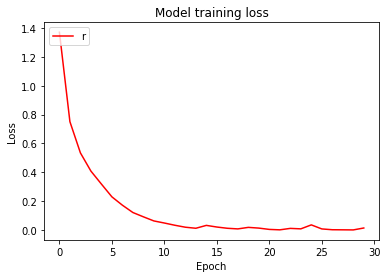

In [10]:
import matplotlib.pyplot as plt
# train loss
plt.plot(history_34.history['loss'], 'r')
#plt.plot(history_50.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend('resnet_34', loc='upper left')
plt.show()

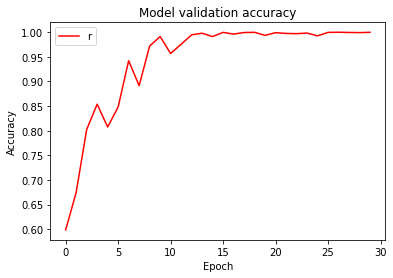

In [11]:
# val acc
plt.plot(history_34.history['val_accuracy'], 'r')
#plt.plot(history_50.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend('resnet_34', loc='upper left')
plt.show()

Epoch 1/30


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


 20/508 [>.............................] - ETA: 1:10 - loss: 2.0297 - accuracy: 0.5469

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


126/508 [======>.......................] - ETA: 1:17 - loss: 1.8016 - accuracy: 0.5575

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


171/508 [=========>....................] - ETA: 1:03 - loss: 1.7486 - accuracy: 0.5557

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


201/508 [==========>...................] - ETA: 55s - loss: 1.6994 - accuracy: 0.5602

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


223/508 [============>.................] - ETA: 50s - loss: 1.6608 - accuracy: 0.5647

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


226/508 [============>.................] - ETA: 49s - loss: 1.6569 - accuracy: 0.5651

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


239/508 [=============>................] - ETA: 46s - loss: 1.6448 - accuracy: 0.5662

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


281/508 [===============>..............] - ETA: 44s - loss: 1.5759 - accuracy: 0.5770

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


370/508 [====================>.........] - ETA: 25s - loss: 1.4747 - accuracy: 0.5869

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


382/508 [=====================>........] - ETA: 22s - loss: 1.4702 - accuracy: 0.5866

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


406/508 [======================>.......] - ETA: 18s - loss: 1.4523 - accuracy: 0.5872

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


414/508 [=======================>......] - ETA: 16s - loss: 1.4448 - accuracy: 0.5878

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


458/508 [==========================>...] - ETA: 8s - loss: 1.4092 - accuracy: 0.5901

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


508/508 [==============================] - ETA: 0s - loss: 1.3696 - accuracy: 0.5948

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


508/508 [==============================] - 142s 235ms/step - loss: 1.3696 - accuracy: 0.5948 - val_loss: 1.3364 - val_accuracy: 0.5351
Epoch 2/30
  2/508 [..............................] - ETA: 1:20 - loss: 1.1106 - accuracy: 0.6094

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


105/508 [=====>........................] - ETA: 57s - loss: 0.9686 - accuracy: 0.6238

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


107/508 [=====>........................] - ETA: 57s - loss: 0.9732 - accuracy: 0.6215

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


142/508 [=======>......................] - ETA: 52s - loss: 0.9580 - accuracy: 0.6254

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


157/508 [========>.....................] - ETA: 50s - loss: 0.9542 - accuracy: 0.6264

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


159/508 [========>.....................] - ETA: 50s - loss: 0.9570 - accuracy: 0.6256

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


169/508 [========>.....................] - ETA: 48s - loss: 0.9414 - accuracy: 0.6302

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


179/508 [=========>....................] - ETA: 59s - loss: 0.9420 - accuracy: 0.6311 

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


265/508 [==============>...............] - ETA: 41s - loss: 0.9024 - accuracy: 0.6387

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


283/508 [===============>..............] - ETA: 37s - loss: 0.8884 - accuracy: 0.6431

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


332/508 [==================>...........] - ETA: 28s - loss: 0.8634 - accuracy: 0.6504

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


361/508 [====================>.........] - ETA: 23s - loss: 0.8586 - accuracy: 0.6510

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


364/508 [====================>.........] - ETA: 23s - loss: 0.8580 - accuracy: 0.6508

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


388/508 [=====================>........] - ETA: 19s - loss: 0.8522 - accuracy: 0.6510

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


393/508 [======================>.......] - ETA: 20s - loss: 0.8509 - accuracy: 0.6512

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


453/508 [=========================>....] - ETA: 9s - loss: 0.8325 - accuracy: 0.6553

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


489/508 [===========================>..] - ETA: 3s - loss: 0.8199 - accuracy: 0.6587

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


497/508 [============================>.] - ETA: 1s - loss: 0.8162 - accuracy: 0.6602

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


508/508 [==============================] - ETA: 0s - loss: 0.8130 - accuracy: 0.6609

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


508/508 [==============================] - 110s 217ms/step - loss: 0.8130 - accuracy: 0.6609 - val_loss: 0.6807 - val_accuracy: 0.6991
Epoch 3/30
 25/508 [>.............................] - ETA: 1:09 - loss: 0.7564 - accuracy: 0.6900

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 93/508 [====>.........................] - ETA: 59s - loss: 0.6898 - accuracy: 0.7031 

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 98/508 [====>.........................] - ETA: 59s - loss: 0.6869 - accuracy: 0.7033

 99/508 [====>.........................] - ETA: 59s - loss: 0.6892 - accuracy: 0.7021

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


104/508 [=====>........................] - ETA: 1:13 - loss: 0.6812 - accuracy: 0.7032

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


158/508 [========>.....................] - ETA: 59s - loss: 0.6597 - accuracy: 0.7046

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


167/508 [========>.....................] - ETA: 57s - loss: 0.6549 - accuracy: 0.7069

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


200/508 [==========>...................] - ETA: 50s - loss: 0.6533 - accuracy: 0.7077

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


232/508 [============>.................] - ETA: 44s - loss: 0.6440 - accuracy: 0.7095

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


237/508 [============>.................] - ETA: 43s - loss: 0.6430 - accuracy: 0.7100

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


286/508 [===============>..............] - ETA: 34s - loss: 0.6380 - accuracy: 0.7083

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


288/508 [================>.............] - ETA: 34s - loss: 0.6385 - accuracy: 0.7083

294/508 [================>.............] - ETA: 33s - loss: 0.6357 - accuracy: 0.7097

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


301/508 [================>.............] - ETA: 32s - loss: 0.6336 - accuracy: 0.7100

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


303/508 [================>.............] - ETA: 32s - loss: 0.6327 - accuracy: 0.7101

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


308/508 [=================>............] - ETA: 31s - loss: 0.6311 - accuracy: 0.7109

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


323/508 [==================>...........] - ETA: 29s - loss: 0.6243 - accuracy: 0.7143

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


344/508 [===================>..........] - ETA: 25s - loss: 0.6179 - accuracy: 0.7169

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


371/508 [====================>.........] - ETA: 21s - loss: 0.6144 - accuracy: 0.7203

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


396/508 [======================>.......] - ETA: 17s - loss: 0.6101 - accuracy: 0.7213

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


401/508 [======================>.......] - ETA: 16s - loss: 0.6094 - accuracy: 0.7214

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


438/508 [========================>.....] - ETA: 10s - loss: 0.6065 - accuracy: 0.7231

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


441/508 [=========================>....] - ETA: 10s - loss: 0.6057 - accuracy: 0.7235

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


445/508 [=========================>....] - ETA: 9s - loss: 0.6035 - accuracy: 0.7247

448/508 [=========================>....] - ETA: 9s - loss: 0.6037 - accuracy: 0.7244

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


451/508 [=========================>....] - ETA: 8s - loss: 0.6028 - accuracy: 0.7246

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


457/508 [=========================>....] - ETA: 7s - loss: 0.6013 - accuracy: 0.7253

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


462/508 [==========================>...] - ETA: 7s - loss: 0.5996 - accuracy: 0.7258

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


484/508 [===========================>..] - ETA: 3s - loss: 0.5978 - accuracy: 0.7261

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


508/508 [==============================] - ETA: 0s - loss: 0.5965 - accuracy: 0.7268

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


508/508 [==============================] - 99s 194ms/step - loss: 0.5965 - accuracy: 0.7268 - val_loss: 0.6195 - val_accuracy: 0.7096
Epoch 4/30
 28/508 [>.............................] - ETA: 1:08 - loss: 0.5220 - accuracy: 0.7433

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 61/508 [==>...........................] - ETA: 1:03 - loss: 0.4836 - accuracy: 0.7695

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 64/508 [==>...........................] - ETA: 1:03 - loss: 0.4846 - accuracy: 0.7690

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 96/508 [====>.........................] - ETA: 58s - loss: 0.4908 - accuracy: 0.7673

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


102/508 [=====>........................] - ETA: 58s - loss: 0.4893 - accuracy: 0.7678

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


151/508 [=======>......................] - ETA: 51s - loss: 0.4866 - accuracy: 0.7709

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


157/508 [========>.....................] - ETA: 51s - loss: 0.4873 - accuracy: 0.7707

162/508 [========>.....................] - ETA: 50s - loss: 0.4854 - accuracy: 0.7712

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


168/508 [========>.....................] - ETA: 49s - loss: 0.4878 - accuracy: 0.7692

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


169/508 [========>.....................] - ETA: 49s - loss: 0.4871 - accuracy: 0.7698

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


190/508 [==========>...................] - ETA: 46s - loss: 0.4848 - accuracy: 0.7719

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


208/508 [===========>..................] - ETA: 45s - loss: 0.4834 - accuracy: 0.7740

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


258/508 [==============>...............] - ETA: 37s - loss: 0.4847 - accuracy: 0.7751

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


286/508 [===============>..............] - ETA: 33s - loss: 0.4857 - accuracy: 0.7752

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


292/508 [================>.............] - ETA: 32s - loss: 0.4852 - accuracy: 0.7753

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


302/508 [================>.............] - ETA: 30s - loss: 0.4846 - accuracy: 0.7752

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


373/508 [=====================>........] - ETA: 19s - loss: 0.4784 - accuracy: 0.7788

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


375/508 [=====================>........] - ETA: 19s - loss: 0.4779 - accuracy: 0.7789

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


378/508 [=====================>........] - ETA: 19s - loss: 0.4766 - accuracy: 0.7796

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


383/508 [=====================>........] - ETA: 18s - loss: 0.4762 - accuracy: 0.7800

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


385/508 [=====================>........] - ETA: 18s - loss: 0.4752 - accuracy: 0.7806

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


389/508 [=====================>........] - ETA: 17s - loss: 0.4739 - accuracy: 0.7814

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


420/508 [=======================>......] - ETA: 13s - loss: 0.4711 - accuracy: 0.7822

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


477/508 [===========================>..] - ETA: 4s - loss: 0.4672 - accuracy: 0.7838

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


508/508 [==============================] - ETA: 0s - loss: 0.4661 - accuracy: 0.7836

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


508/508 [==============================] - 97s 192ms/step - loss: 0.4661 - accuracy: 0.7836 - val_loss: 0.4138 - val_accuracy: 0.8185
Epoch 5/30
  3/508 [..............................] - ETA: 1:20 - loss: 0.3893 - accuracy: 0.8021

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 15/508 [..............................] - ETA: 1:11 - loss: 0.4445 - accuracy: 0.7937

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 39/508 [=>............................] - ETA: 1:07 - loss: 0.4378 - accuracy: 0.8061

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 43/508 [=>............................] - ETA: 1:06 - loss: 0.4262 - accuracy: 0.8132

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


 73/508 [===>..........................] - ETA: 1:02 - loss: 0.4173 - accuracy: 0.8198

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 87/508 [====>.........................] - ETA: 1:01 - loss: 0.4179 - accuracy: 0.8168

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 93/508 [====>.........................] - ETA: 1:00 - loss: 0.4185 - accuracy: 0.8169

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


 99/508 [====>.........................] - ETA: 59s - loss: 0.4191 - accuracy: 0.8150

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


102/508 [=====>........................] - ETA: 59s - loss: 0.4209 - accuracy: 0.8156

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


130/508 [======>.......................] - ETA: 55s - loss: 0.4102 - accuracy: 0.8200

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


192/508 [==========>...................] - ETA: 47s - loss: 0.4039 - accuracy: 0.8212

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


206/508 [===========>..................] - ETA: 45s - loss: 0.4048 - accuracy: 0.8211

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


211/508 [===========>..................] - ETA: 44s - loss: 0.4031 - accuracy: 0.8212

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


242/508 [=============>................] - ETA: 39s - loss: 0.4063 - accuracy: 0.8188

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


248/508 [=============>................] - ETA: 38s - loss: 0.4053 - accuracy: 0.8198

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


299/508 [================>.............] - ETA: 30s - loss: 0.3991 - accuracy: 0.8217

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


306/508 [=================>............] - ETA: 29s - loss: 0.3979 - accuracy: 0.8227

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


314/508 [=================>............] - ETA: 28s - loss: 0.3972 - accuracy: 0.8231

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


320/508 [=================>............] - ETA: 27s - loss: 0.3980 - accuracy: 0.8230

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


322/508 [==================>...........] - ETA: 27s - loss: 0.3984 - accuracy: 0.8229

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


347/508 [===================>..........] - ETA: 23s - loss: 0.3948 - accuracy: 0.8251

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


355/508 [===================>..........] - ETA: 22s - loss: 0.3937 - accuracy: 0.8253

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


425/508 [========================>.....] - ETA: 12s - loss: 0.3848 - accuracy: 0.8303

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


427/508 [========================>.....] - ETA: 11s - loss: 0.3843 - accuracy: 0.8304

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


458/508 [==========================>...] - ETA: 7s - loss: 0.3830 - accuracy: 0.8321

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


464/508 [==========================>...] - ETA: 6s - loss: 0.3826 - accuracy: 0.8321

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


508/508 [==============================] - ETA: 0s - loss: 0.3802 - accuracy: 0.8327

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 

508/508 [==============================] - 99s 194ms/step - loss: 0.3802 - accuracy: 0.8327 - val_loss: 0.4084 - val_accuracy: 0.8184
Epoch 6/30
 32/508 [>.............................] - ETA: 1:07 - loss: 0.2909 - accuracy: 0.8789

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


 39/508 [=>............................] - ETA: 1:06 - loss: 0.2815 - accuracy: 0.8854

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


118/508 [=====>........................] - ETA: 59s - loss: 0.2934 - accuracy: 0.8767

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


144/508 [=======>......................] - ETA: 54s - loss: 0.3081 - accuracy: 0.8692

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


164/508 [========>.....................] - ETA: 51s - loss: 0.3149 - accuracy: 0.8663

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


167/508 [========>.....................] - ETA: 51s - loss: 0.3141 - accuracy: 0.8670

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


228/508 [============>.................] - ETA: 41s - loss: 0.3121 - accuracy: 0.8675

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


235/508 [============>.................] - ETA: 40s - loss: 0.3113 - accuracy: 0.8678

237/508 [============>.................] - ETA: 40s - loss: 0.3108 - accuracy: 0.8682

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


241/508 [=============>................] - ETA: 39s - loss: 0.3121 - accuracy: 0.8678

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


244/508 [=============>................] - ETA: 39s - loss: 0.3117 - accuracy: 0.8684

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


247/508 [=============>................] - ETA: 38s - loss: 0.3123 - accuracy: 0.8679

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


249/508 [=============>................] - ETA: 38s - loss: 0.3122 - accuracy: 0.8674

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


276/508 [===============>..............] - ETA: 34s - loss: 0.3095 - accuracy: 0.8691

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


356/508 [====================>.........] - ETA: 22s - loss: 0.2971 - accuracy: 0.8766

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


361/508 [====================>.........] - ETA: 21s - loss: 0.2960 - accuracy: 0.8772

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


379/508 [=====================>........] - ETA: 19s - loss: 0.2952 - accuracy: 0.8777

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


404/508 [======================>.......] - ETA: 15s - loss: 0.2948 - accuracy: 0.8781

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


411/508 [=======================>......] - ETA: 14s - loss: 0.2948 - accuracy: 0.8782

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


446/508 [=========================>....] - ETA: 9s - loss: 0.2949 - accuracy: 0.8778

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


453/508 [=========================>....] - ETA: 8s - loss: 0.2953 - accuracy: 0.8774

457/508 [=========================>....] - ETA: 7s - loss: 0.2949 - accuracy: 0.8777

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


460/508 [==========================>...] - ETA: 7s - loss: 0.2949 - accuracy: 0.8776

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


465/508 [==========================>...] - ETA: 6s - loss: 0.2939 - accuracy: 0.8782

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


477/508 [===========================>..] - ETA: 4s - loss: 0.2937 - accuracy: 0.8784

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


508/508 [==============================] - ETA: 0s - loss: 0.2916 - accuracy: 0.8797

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


508/508 [==============================] - 98s 193ms/step - loss: 0.2916 - accuracy: 0.8797 - val_loss: 0.2353 - val_accuracy: 0.9031
Epoch 7/30
 16/508 [..............................] - ETA: 1:10 - loss: 0.2353 - accuracy: 0.9043

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 49/508 [=>............................] - ETA: 1:05 - loss: 0.2228 - accuracy: 0.9069

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 84/508 [===>..........................] - ETA: 1:00 - loss: 0.2404 - accuracy: 0.8984

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 91/508 [====>.........................] - ETA: 59s - loss: 0.2355 - accuracy: 0.9005

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


115/508 [=====>........................] - ETA: 55s - loss: 0.2393 - accuracy: 0.8995

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


161/508 [========>.....................] - ETA: 49s - loss: 0.2335 - accuracy: 0.9030

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


167/508 [========>.....................] - ETA: 49s - loss: 0.2323 - accuracy: 0.9033

168/508 [========>.....................] - ETA: 49s - loss: 0.2327 - accuracy: 0.9031

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


174/508 [=========>....................] - ETA: 48s - loss: 0.2329 - accuracy: 0.9031

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


178/508 [=========>....................] - ETA: 47s - loss: 0.2325 - accuracy: 0.9033

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


179/508 [=========>....................] - ETA: 47s - loss: 0.2317 - accuracy: 0.9035

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


207/508 [===========>..................] - ETA: 43s - loss: 0.2283 - accuracy: 0.9072

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


244/508 [=============>................] - ETA: 38s - loss: 0.2289 - accuracy: 0.9075

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


292/508 [================>.............] - ETA: 31s - loss: 0.2288 - accuracy: 0.9084

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


312/508 [=================>............] - ETA: 28s - loss: 0.2264 - accuracy: 0.9094

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


335/508 [==================>...........] - ETA: 24s - loss: 0.2226 - accuracy: 0.9106

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


341/508 [===================>..........] - ETA: 24s - loss: 0.2219 - accuracy: 0.9108

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


377/508 [=====================>........] - ETA: 18s - loss: 0.2212 - accuracy: 0.9108

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


382/508 [=====================>........] - ETA: 18s - loss: 0.2207 - accuracy: 0.9109

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


384/508 [=====================>........] - ETA: 17s - loss: 0.2208 - accuracy: 0.9110

391/508 [======================>.......] - ETA: 16s - loss: 0.2190 - accuracy: 0.9115

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


394/508 [======================>.......] - ETA: 16s - loss: 0.2193 - accuracy: 0.9116

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


396/508 [======================>.......] - ETA: 16s - loss: 0.2189 - accuracy: 0.9117

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


398/508 [======================>.......] - ETA: 15s - loss: 0.2184 - accuracy: 0.9118

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


422/508 [=======================>......] - ETA: 12s - loss: 0.2159 - accuracy: 0.9128

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


447/508 [=========================>....] - ETA: 8s - loss: 0.2139 - accuracy: 0.9133

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


479/508 [===========================>..] - ETA: 4s - loss: 0.2142 - accuracy: 0.9133

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


486/508 [===========================>..] - ETA: 3s - loss: 0.2137 - accuracy: 0.9133

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


494/508 [============================>.] - ETA: 2s - loss: 0.2129 - accuracy: 0.9135

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


508/508 [==============================] - ETA: 0s - loss: 0.2111 - accuracy: 0.9143

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


508/508 [==============================] - 96s 190ms/step - loss: 0.2111 - accuracy: 0.9143 - val_loss: 0.2137 - val_accuracy: 0.9138
Epoch 8/30
 18/508 [>.............................] - ETA: 1:09 - loss: 0.2118 - accuracy: 0.9097

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 91/508 [====>.........................] - ETA: 1:00 - loss: 0.1865 - accuracy: 0.9258

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 98/508 [====>.........................] - ETA: 59s - loss: 0.1835 - accuracy: 0.9273

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


101/508 [====>.........................] - ETA: 58s - loss: 0.1827 - accuracy: 0.9269

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


105/508 [=====>........................] - ETA: 58s - loss: 0.1792 - accuracy: 0.9286

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


111/508 [=====>........................] - ETA: 57s - loss: 0.1788 - accuracy: 0.9293

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


140/508 [=======>......................] - ETA: 53s - loss: 0.1840 - accuracy: 0.9301

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


197/508 [==========>...................] - ETA: 45s - loss: 0.1728 - accuracy: 0.9331

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


219/508 [===========>..................] - ETA: 41s - loss: 0.1664 - accuracy: 0.9360

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


231/508 [============>.................] - ETA: 40s - loss: 0.1660 - accuracy: 0.9359

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


254/508 [==============>...............] - ETA: 36s - loss: 0.1616 - accuracy: 0.9372

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


260/508 [==============>...............] - ETA: 35s - loss: 0.1612 - accuracy: 0.9376

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


305/508 [=================>............] - ETA: 29s - loss: 0.1592 - accuracy: 0.9383

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


308/508 [=================>............] - ETA: 28s - loss: 0.1584 - accuracy: 0.9386

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


313/508 [=================>............] - ETA: 28s - loss: 0.1581 - accuracy: 0.9389

320/508 [=================>............] - ETA: 27s - loss: 0.1589 - accuracy: 0.9383

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


326/508 [==================>...........] - ETA: 26s - loss: 0.1585 - accuracy: 0.9386

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


328/508 [==================>...........] - ETA: 26s - loss: 0.1579 - accuracy: 0.9389

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


330/508 [==================>...........] - ETA: 25s - loss: 0.1583 - accuracy: 0.9389

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


350/508 [===================>..........] - ETA: 22s - loss: 0.1560 - accuracy: 0.9397

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


372/508 [====================>.........] - ETA: 19s - loss: 0.1531 - accuracy: 0.9401

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


439/508 [========================>.....] - ETA: 9s - loss: 0.1470 - accuracy: 0.9421 

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


466/508 [==========================>...] - ETA: 6s - loss: 0.1457 - accuracy: 0.9427

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


488/508 [===========================>..] - ETA: 2s - loss: 0.1442 - accuracy: 0.9432

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


492/508 [============================>.] - ETA: 2s - loss: 0.1433 - accuracy: 0.9436

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


508/508 [==============================] - ETA: 0s - loss: 0.1431 - accuracy: 0.9440

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0x

508/508 [==============================] - 100s 197ms/step - loss: 0.1431 - accuracy: 0.9440 - val_loss: 0.1062 - val_accuracy: 0.9612
Epoch 9/30
 64/508 [==>...........................] - ETA: 1:03 - loss: 0.1234 - accuracy: 0.9492

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


124/508 [======>.......................] - ETA: 54s - loss: 0.1156 - accuracy: 0.9541

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


133/508 [======>.......................] - ETA: 53s - loss: 0.1164 - accuracy: 0.9542

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


160/508 [========>.....................] - ETA: 49s - loss: 0.1212 - accuracy: 0.9547

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


166/508 [========>.....................] - ETA: 48s - loss: 0.1216 - accuracy: 0.9544

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


195/508 [==========>...................] - ETA: 44s - loss: 0.1248 - accuracy: 0.9535

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


242/508 [=============>................] - ETA: 38s - loss: 0.1331 - accuracy: 0.9489

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


244/508 [=============>................] - ETA: 38s - loss: 0.1326 - accuracy: 0.9490

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


249/508 [=============>................] - ETA: 37s - loss: 0.1320 - accuracy: 0.9493

255/508 [==============>...............] - ETA: 36s - loss: 0.1321 - accuracy: 0.9494

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


258/508 [==============>...............] - ETA: 36s - loss: 0.1324 - accuracy: 0.9491

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


260/508 [==============>...............] - ETA: 35s - loss: 0.1331 - accuracy: 0.9490

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


289/508 [================>.............] - ETA: 31s - loss: 0.1336 - accuracy: 0.9482

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


324/508 [==================>...........] - ETA: 26s - loss: 0.1331 - accuracy: 0.9477

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


330/508 [==================>...........] - ETA: 25s - loss: 0.1316 - accuracy: 0.9485

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


372/508 [====================>.........] - ETA: 19s - loss: 0.1336 - accuracy: 0.9477

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


408/508 [=======================>......] - ETA: 14s - loss: 0.1329 - accuracy: 0.9486

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


414/508 [=======================>......] - ETA: 13s - loss: 0.1328 - accuracy: 0.9486

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


455/508 [=========================>....] - ETA: 7s - loss: 0.1314 - accuracy: 0.9487

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


462/508 [==========================>...] - ETA: 6s - loss: 0.1314 - accuracy: 0.9486

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


466/508 [==========================>...] - ETA: 6s - loss: 0.1307 - accuracy: 0.9489

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


469/508 [==========================>...] - ETA: 5s - loss: 0.1303 - accuracy: 0.9491

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


488/508 [===========================>..] - ETA: 2s - loss: 0.1292 - accuracy: 0.9497

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


490/508 [===========================>..] - ETA: 2s - loss: 0.1288 - accuracy: 0.9498

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


508/508 [==============================] - ETA: 0s - loss: 0.1282 - accuracy: 0.9502

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


508/508 [==============================] - 98s 191ms/step - loss: 0.1282 - accuracy: 0.9502 - val_loss: 0.3793 - val_accuracy: 0.8554
Epoch 10/30
 49/508 [=>............................] - ETA: 1:05 - loss: 0.0671 - accuracy: 0.9790

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 66/508 [==>...........................] - ETA: 1:02 - loss: 0.0766 - accuracy: 0.9759

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 84/508 [===>..........................] - ETA: 1:00 - loss: 0.0864 - accuracy: 0.9721

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 93/508 [====>.........................] - ETA: 59s - loss: 0.0937 - accuracy: 0.9688

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 99/508 [====>.........................] - ETA: 58s - loss: 0.0909 - accuracy: 0.9694

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


163/508 [========>.....................] - ETA: 49s - loss: 0.0942 - accuracy: 0.9691

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


168/508 [========>.....................] - ETA: 49s - loss: 0.0958 - accuracy: 0.9689

170/508 [=========>....................] - ETA: 48s - loss: 0.0963 - accuracy: 0.9684

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


174/508 [=========>....................] - ETA: 48s - loss: 0.1017 - accuracy: 0.9677

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


180/508 [=========>....................] - ETA: 47s - loss: 0.1020 - accuracy: 0.9674

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


183/508 [=========>....................] - ETA: 47s - loss: 0.1009 - accuracy: 0.9679

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


192/508 [==========>...................] - ETA: 45s - loss: 0.0999 - accuracy: 0.9679

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


202/508 [==========>...................] - ETA: 44s - loss: 0.1026 - accuracy: 0.9677

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


259/508 [==============>...............] - ETA: 36s - loss: 0.0946 - accuracy: 0.9696

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


270/508 [==============>...............] - ETA: 34s - loss: 0.0934 - accuracy: 0.9699

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


342/508 [===================>..........] - ETA: 23s - loss: 0.0968 - accuracy: 0.9689

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


352/508 [===================>..........] - ETA: 22s - loss: 0.0990 - accuracy: 0.9681

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


354/508 [===================>..........] - ETA: 22s - loss: 0.1008 - accuracy: 0.9677

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


382/508 [=====================>........] - ETA: 18s - loss: 0.1011 - accuracy: 0.9674

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


383/508 [=====================>........] - ETA: 18s - loss: 0.1010 - accuracy: 0.9675

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


391/508 [======================>.......] - ETA: 17s - loss: 0.1005 - accuracy: 0.9677

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


398/508 [======================>.......] - ETA: 16s - loss: 0.0999 - accuracy: 0.9679

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


400/508 [======================>.......] - ETA: 15s - loss: 0.0999 - accuracy: 0.9678

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


403/508 [======================>.......] - ETA: 15s - loss: 0.0995 - accuracy: 0.9678

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


493/508 [============================>.] - ETA: 2s - loss: 0.0943 - accuracy: 0.9692

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


508/508 [==============================] - ETA: 0s - loss: 0.0951 - accuracy: 0.9687

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


508/508 [==============================] - 95s 188ms/step - loss: 0.0951 - accuracy: 0.9687 - val_loss: 0.0872 - val_accuracy: 0.9709
Epoch 11/30
 10/508 [..............................] - ETA: 1:11 - loss: 0.0694 - accuracy: 0.9750

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 40/508 [=>............................] - ETA: 1:06 - loss: 0.0936 - accuracy: 0.9656

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 48/508 [=>............................] - ETA: 1:04 - loss: 0.0886 - accuracy: 0.9681

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


103/508 [=====>........................] - ETA: 58s - loss: 0.0897 - accuracy: 0.9679

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


112/508 [=====>........................] - ETA: 57s - loss: 0.0866 - accuracy: 0.9693

114/508 [=====>........................] - ETA: 56s - loss: 0.0854 - accuracy: 0.9699

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


118/508 [=====>........................] - ETA: 56s - loss: 0.0828 - accuracy: 0.9709

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


124/508 [======>.......................] - ETA: 55s - loss: 0.0812 - accuracy: 0.9713

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


152/508 [=======>......................] - ETA: 51s - loss: 0.0800 - accuracy: 0.9709

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


174/508 [=========>....................] - ETA: 48s - loss: 0.0820 - accuracy: 0.9710

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


236/508 [============>.................] - ETA: 39s - loss: 0.0810 - accuracy: 0.9713

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


239/508 [=============>................] - ETA: 38s - loss: 0.0802 - accuracy: 0.9717

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


269/508 [==============>...............] - ETA: 34s - loss: 0.0811 - accuracy: 0.9721

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


274/508 [===============>..............] - ETA: 33s - loss: 0.0801 - accuracy: 0.9724

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


316/508 [=================>............] - ETA: 27s - loss: 0.0751 - accuracy: 0.9745

318/508 [=================>............] - ETA: 27s - loss: 0.0748 - accuracy: 0.9745

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


323/508 [==================>...........] - ETA: 26s - loss: 0.0743 - accuracy: 0.9747

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


324/508 [==================>...........] - ETA: 26s - loss: 0.0741 - accuracy: 0.9748

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


328/508 [==================>...........] - ETA: 26s - loss: 0.0735 - accuracy: 0.9750

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


332/508 [==================>...........] - ETA: 25s - loss: 0.0734 - accuracy: 0.9750

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


335/508 [==================>...........] - ETA: 25s - loss: 0.0739 - accuracy: 0.9748

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


349/508 [===================>..........] - ETA: 23s - loss: 0.0725 - accuracy: 0.9753

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


387/508 [=====================>........] - ETA: 17s - loss: 0.0723 - accuracy: 0.9754

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


462/508 [==========================>...] - ETA: 6s - loss: 0.0695 - accuracy: 0.9762

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


468/508 [==========================>...] - ETA: 5s - loss: 0.0690 - accuracy: 0.9764

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


495/508 [============================>.] - ETA: 1s - loss: 0.0689 - accuracy: 0.9763

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


500/508 [============================>.] - ETA: 1s - loss: 0.0685 - accuracy: 0.9765

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


508/508 [==============================] - ETA: 0s - loss: 0.0686 - accuracy: 0.9765

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0x

508/508 [==============================] - 98s 192ms/step - loss: 0.0686 - accuracy: 0.9765 - val_loss: 0.0723 - val_accuracy: 0.9735
Epoch 12/30
 28/508 [>.............................] - ETA: 1:08 - loss: 0.0307 - accuracy: 0.9922

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


126/508 [======>.......................] - ETA: 54s - loss: 0.0329 - accuracy: 0.9901

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


173/508 [=========>....................] - ETA: 47s - loss: 0.0317 - accuracy: 0.9901

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


204/508 [===========>..................] - ETA: 43s - loss: 0.0315 - accuracy: 0.9899

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


209/508 [===========>..................] - ETA: 42s - loss: 0.0319 - accuracy: 0.9897

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


258/508 [==============>...............] - ETA: 36s - loss: 0.0336 - accuracy: 0.9887

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


263/508 [==============>...............] - ETA: 35s - loss: 0.0340 - accuracy: 0.9885

267/508 [==============>...............] - ETA: 34s - loss: 0.0340 - accuracy: 0.9883

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


270/508 [==============>...............] - ETA: 34s - loss: 0.0337 - accuracy: 0.9884

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


278/508 [===============>..............] - ETA: 33s - loss: 0.0334 - accuracy: 0.9888

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


279/508 [===============>..............] - ETA: 33s - loss: 0.0334 - accuracy: 0.9888

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


307/508 [=================>............] - ETA: 29s - loss: 0.0326 - accuracy: 0.9891

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


316/508 [=================>............] - ETA: 27s - loss: 0.0323 - accuracy: 0.9891

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


361/508 [====================>.........] - ETA: 21s - loss: 0.0320 - accuracy: 0.9887

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


377/508 [=====================>........] - ETA: 19s - loss: 0.0317 - accuracy: 0.9888

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


398/508 [======================>.......] - ETA: 16s - loss: 0.0312 - accuracy: 0.9890

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


406/508 [======================>.......] - ETA: 14s - loss: 0.0320 - accuracy: 0.9889

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


463/508 [==========================>...] - ETA: 6s - loss: 0.0325 - accuracy: 0.9888

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


469/508 [==========================>...] - ETA: 5s - loss: 0.0326 - accuracy: 0.9887

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


475/508 [===========================>..] - ETA: 4s - loss: 0.0325 - accuracy: 0.9888

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


478/508 [===========================>..] - ETA: 4s - loss: 0.0325 - accuracy: 0.9888

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


481/508 [===========================>..] - ETA: 3s - loss: 0.0326 - accuracy: 0.9887

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


508/508 [==============================] - ETA: 0s - loss: 0.0320 - accuracy: 0.9889

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


508/508 [==============================] - 95s 187ms/step - loss: 0.0320 - accuracy: 0.9889 - val_loss: 0.0961 - val_accuracy: 0.9693
Epoch 13/30
 72/508 [===>..........................] - ETA: 1:02 - loss: 0.0190 - accuracy: 0.9939

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 74/508 [===>..........................] - ETA: 1:01 - loss: 0.0186 - accuracy: 0.9941

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 92/508 [====>.........................] - ETA: 59s - loss: 0.0187 - accuracy: 0.9946

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


126/508 [======>.......................] - ETA: 54s - loss: 0.0188 - accuracy: 0.9945

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


133/508 [======>.......................] - ETA: 53s - loss: 0.0181 - accuracy: 0.9948

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


178/508 [=========>....................] - ETA: 47s - loss: 0.0181 - accuracy: 0.9946

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


185/508 [=========>....................] - ETA: 46s - loss: 0.0184 - accuracy: 0.9946

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


191/508 [==========>...................] - ETA: 45s - loss: 0.0182 - accuracy: 0.9948

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


194/508 [==========>...................] - ETA: 45s - loss: 0.0180 - accuracy: 0.9948

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


198/508 [==========>...................] - ETA: 44s - loss: 0.0177 - accuracy: 0.9949

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


212/508 [===========>..................] - ETA: 43s - loss: 0.0179 - accuracy: 0.9950

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


249/508 [=============>................] - ETA: 37s - loss: 0.0176 - accuracy: 0.9950

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


297/508 [================>.............] - ETA: 30s - loss: 0.0182 - accuracy: 0.9946

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


331/508 [==================>...........] - ETA: 25s - loss: 0.0192 - accuracy: 0.9942

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


358/508 [====================>.........] - ETA: 21s - loss: 0.0192 - accuracy: 0.9942

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


363/508 [====================>.........] - ETA: 20s - loss: 0.0192 - accuracy: 0.9941

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


394/508 [======================>.......] - ETA: 16s - loss: 0.0190 - accuracy: 0.9941

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


408/508 [=======================>......] - ETA: 14s - loss: 0.0186 - accuracy: 0.9943

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


418/508 [=======================>......] - ETA: 13s - loss: 0.0187 - accuracy: 0.9943

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


424/508 [========================>.....] - ETA: 12s - loss: 0.0185 - accuracy: 0.9944

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


426/508 [========================>.....] - ETA: 11s - loss: 0.0184 - accuracy: 0.9944

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


451/508 [=========================>....] - ETA: 8s - loss: 0.0181 - accuracy: 0.9945

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


456/508 [=========================>....] - ETA: 7s - loss: 0.0179 - accuracy: 0.9946

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


508/508 [==============================] - ETA: 0s - loss: 0.0182 - accuracy: 0.9943

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


508/508 [==============================] - 97s 192ms/step - loss: 0.0182 - accuracy: 0.9943 - val_loss: 0.0229 - val_accuracy: 0.9908
Epoch 14/30
 30/508 [>.............................] - ETA: 1:08 - loss: 0.0190 - accuracy: 0.9927

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 59/508 [==>...........................] - ETA: 1:03 - loss: 0.0165 - accuracy: 0.9952

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 67/508 [==>...........................] - ETA: 1:01 - loss: 0.0173 - accuracy: 0.9938

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


101/508 [====>.........................] - ETA: 57s - loss: 0.0196 - accuracy: 0.9924

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


103/508 [=====>........................] - ETA: 57s - loss: 0.0193 - accuracy: 0.9926

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


114/508 [=====>........................] - ETA: 56s - loss: 0.0181 - accuracy: 0.9933

121/508 [======>.......................] - ETA: 55s - loss: 0.0177 - accuracy: 0.9932

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


125/508 [======>.......................] - ETA: 55s - loss: 0.0177 - accuracy: 0.9932

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


126/508 [======>.......................] - ETA: 55s - loss: 0.0176 - accuracy: 0.9932

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


155/508 [========>.....................] - ETA: 51s - loss: 0.0167 - accuracy: 0.9937

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


231/508 [============>.................] - ETA: 40s - loss: 0.0155 - accuracy: 0.9943

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


257/508 [==============>...............] - ETA: 36s - loss: 0.0179 - accuracy: 0.9938

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


283/508 [===============>..............] - ETA: 32s - loss: 0.0172 - accuracy: 0.9940

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


287/508 [===============>..............] - ETA: 31s - loss: 0.0171 - accuracy: 0.9941

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


324/508 [==================>...........] - ETA: 26s - loss: 0.0180 - accuracy: 0.9941

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


330/508 [==================>...........] - ETA: 25s - loss: 0.0177 - accuracy: 0.9942

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


336/508 [==================>...........] - ETA: 24s - loss: 0.0175 - accuracy: 0.9943

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


345/508 [===================>..........] - ETA: 23s - loss: 0.0172 - accuracy: 0.9944

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


346/508 [===================>..........] - ETA: 23s - loss: 0.0171 - accuracy: 0.9945

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


356/508 [====================>.........] - ETA: 22s - loss: 0.0168 - accuracy: 0.9945

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


437/508 [========================>.....] - ETA: 10s - loss: 0.0156 - accuracy: 0.9950

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


449/508 [=========================>....] - ETA: 8s - loss: 0.0162 - accuracy: 0.9949

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


474/508 [==========================>...] - ETA: 4s - loss: 0.0156 - accuracy: 0.9952

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


503/508 [============================>.] - ETA: 0s - loss: 0.0150 - accuracy: 0.9954

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


508/508 [==============================] - ETA: 0s - loss: 0.0149 - accuracy: 0.9954

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


508/508 [==============================] - 96s 189ms/step - loss: 0.0149 - accuracy: 0.9954 - val_loss: 0.0332 - val_accuracy: 0.9914
Epoch 15/30
  1/508 [..............................] - ETA: 1:09 - loss: 0.0013 - accuracy: 1.0000

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


 33/508 [>.............................] - ETA: 1:10 - loss: 0.0090 - accuracy: 0.9953

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 36/508 [=>............................] - ETA: 1:10 - loss: 0.0084 - accuracy: 0.9957

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 41/508 [=>............................] - ETA: 1:09 - loss: 0.0077 - accuracy: 0.9962

 48/508 [=>............................] - ETA: 1:08 - loss: 0.0068 - accuracy: 0.9967

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


 53/508 [==>...........................] - ETA: 1:07 - loss: 0.0084 - accuracy: 0.9965

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 60/508 [==>...........................] - ETA: 1:06 - loss: 0.0106 - accuracy: 0.9948

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


 79/508 [===>..........................] - ETA: 1:03 - loss: 0.0083 - accuracy: 0.9960

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 83/508 [===>..........................] - ETA: 1:03 - loss: 0.0082 - accuracy: 0.9962

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


114/508 [=====>........................] - ETA: 57s - loss: 0.0101 - accuracy: 0.9959

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


180/508 [=========>....................] - ETA: 47s - loss: 0.0105 - accuracy: 0.9957

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


205/508 [===========>..................] - ETA: 44s - loss: 0.0100 - accuracy: 0.9959

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


210/508 [===========>..................] - ETA: 45s - loss: 0.0100 - accuracy: 0.9960

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


263/508 [==============>...............] - ETA: 36s - loss: 0.0190 - accuracy: 0.9937

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


266/508 [==============>...............] - ETA: 36s - loss: 0.0189 - accuracy: 0.9938

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


272/508 [===============>..............] - ETA: 35s - loss: 0.0185 - accuracy: 0.9939

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


278/508 [===============>..............] - ETA: 34s - loss: 0.0182 - accuracy: 0.9940

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


282/508 [===============>..............] - ETA: 34s - loss: 0.0180 - accuracy: 0.9941

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


297/508 [================>.............] - ETA: 31s - loss: 0.0175 - accuracy: 0.9943

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


308/508 [=================>............] - ETA: 30s - loss: 0.0173 - accuracy: 0.9943

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


390/508 [======================>.......] - ETA: 17s - loss: 0.0216 - accuracy: 0.9937

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


404/508 [======================>.......] - ETA: 15s - loss: 0.0220 - accuracy: 0.9935

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


412/508 [=======================>......] - ETA: 14s - loss: 0.0227 - accuracy: 0.9931

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


417/508 [=======================>......] - ETA: 13s - loss: 0.0227 - accuracy: 0.9931

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


470/508 [==========================>...] - ETA: 5s - loss: 0.0225 - accuracy: 0.9930

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


479/508 [===========================>..] - ETA: 4s - loss: 0.0244 - accuracy: 0.9927

483/508 [===========================>..] - ETA: 3s - loss: 0.0244 - accuracy: 0.9927

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


486/508 [===========================>..] - ETA: 3s - loss: 0.0244 - accuracy: 0.9927

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


492/508 [============================>.] - ETA: 2s - loss: 0.0255 - accuracy: 0.9924

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


494/508 [============================>.] - ETA: 2s - loss: 0.0254 - accuracy: 0.9924

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


508/508 [==============================] - ETA: 0s - loss: 0.0252 - accuracy: 0.9924

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


508/508 [==============================] - 96s 189ms/step - loss: 0.0252 - accuracy: 0.9924 - val_loss: 0.0605 - val_accuracy: 0.9792
Epoch 16/30
 45/508 [=>............................] - ETA: 1:05 - loss: 0.0338 - accuracy: 0.9861

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 77/508 [===>..........................] - ETA: 1:01 - loss: 0.0241 - accuracy: 0.9899

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


112/508 [=====>........................] - ETA: 56s - loss: 0.0206 - accuracy: 0.9916

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


123/508 [======>.......................] - ETA: 54s - loss: 0.0216 - accuracy: 0.9911

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


179/508 [=========>....................] - ETA: 47s - loss: 0.0209 - accuracy: 0.9926

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


184/508 [=========>....................] - ETA: 46s - loss: 0.0204 - accuracy: 0.9928

193/508 [==========>...................] - ETA: 45s - loss: 0.0196 - accuracy: 0.9932

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


199/508 [==========>...................] - ETA: 44s - loss: 0.0190 - accuracy: 0.9934

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


202/508 [==========>...................] - ETA: 44s - loss: 0.0188 - accuracy: 0.9935

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


207/508 [===========>..................] - ETA: 43s - loss: 0.0184 - accuracy: 0.9936

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


222/508 [============>.................] - ETA: 41s - loss: 0.0172 - accuracy: 0.9941

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


259/508 [==============>...............] - ETA: 36s - loss: 0.0161 - accuracy: 0.9944

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


327/508 [==================>...........] - ETA: 26s - loss: 0.0179 - accuracy: 0.9942

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


349/508 [===================>..........] - ETA: 22s - loss: 0.0173 - accuracy: 0.9942

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


367/508 [====================>.........] - ETA: 20s - loss: 0.0174 - accuracy: 0.9941

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


371/508 [====================>.........] - ETA: 19s - loss: 0.0180 - accuracy: 0.9940

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


402/508 [======================>.......] - ETA: 15s - loss: 0.0202 - accuracy: 0.9935

407/508 [=======================>......] - ETA: 14s - loss: 0.0201 - accuracy: 0.9934

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


412/508 [=======================>......] - ETA: 13s - loss: 0.0200 - accuracy: 0.9935

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


417/508 [=======================>......] - ETA: 13s - loss: 0.0198 - accuracy: 0.9935

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


434/508 [========================>.....] - ETA: 10s - loss: 0.0199 - accuracy: 0.9936

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


508/508 [==============================] - ETA: 0s - loss: 0.0177 - accuracy: 0.9944

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


508/508 [==============================] - 95s 187ms/step - loss: 0.0177 - accuracy: 0.9944 - val_loss: 0.0193 - val_accuracy: 0.9938
Epoch 17/30
 10/508 [..............................] - ETA: 1:11 - loss: 0.0042 - accuracy: 1.0000

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 39/508 [=>............................] - ETA: 1:06 - loss: 0.0034 - accuracy: 0.9992

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 51/508 [==>...........................] - ETA: 1:05 - loss: 0.0055 - accuracy: 0.9982

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 76/508 [===>..........................] - ETA: 1:08 - loss: 0.0099 - accuracy: 0.9971

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 80/508 [===>..........................] - ETA: 1:07 - loss: 0.0105 - accuracy: 0.9968

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


115/508 [=====>........................] - ETA: 1:00 - loss: 0.0115 - accuracy: 0.9967

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


119/508 [======>.......................] - ETA: 1:00 - loss: 0.0113 - accuracy: 0.9968

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


121/508 [======>.......................] - ETA: 59s - loss: 0.0111 - accuracy: 0.9969

128/508 [======>.......................] - ETA: 58s - loss: 0.0108 - accuracy: 0.9970

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


135/508 [======>.......................] - ETA: 57s - loss: 0.0117 - accuracy: 0.9967

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


137/508 [=======>......................] - ETA: 57s - loss: 0.0116 - accuracy: 0.9968

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


166/508 [========>.....................] - ETA: 52s - loss: 0.0115 - accuracy: 0.9970

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


177/508 [=========>....................] - ETA: 50s - loss: 0.0110 - accuracy: 0.9972

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


207/508 [===========>..................] - ETA: 45s - loss: 0.0100 - accuracy: 0.9974

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


226/508 [============>.................] - ETA: 42s - loss: 0.0094 - accuracy: 0.9976

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


261/508 [==============>...............] - ETA: 36s - loss: 0.0096 - accuracy: 0.9974

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


269/508 [==============>...............] - ETA: 35s - loss: 0.0095 - accuracy: 0.9974

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


329/508 [==================>...........] - ETA: 26s - loss: 0.0094 - accuracy: 0.9972

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


336/508 [==================>...........] - ETA: 25s - loss: 0.0093 - accuracy: 0.9973

341/508 [===================>..........] - ETA: 24s - loss: 0.0092 - accuracy: 0.9973

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


348/508 [===================>..........] - ETA: 23s - loss: 0.0090 - accuracy: 0.9974

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


350/508 [===================>..........] - ETA: 23s - loss: 0.0090 - accuracy: 0.9974

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


355/508 [===================>..........] - ETA: 22s - loss: 0.0089 - accuracy: 0.9974

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


371/508 [====================>.........] - ETA: 20s - loss: 0.0088 - accuracy: 0.9975

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


464/508 [==========================>...] - ETA: 6s - loss: 0.0078 - accuracy: 0.9978

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


469/508 [==========================>...] - ETA: 5s - loss: 0.0081 - accuracy: 0.9977

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


496/508 [============================>.] - ETA: 1s - loss: 0.0079 - accuracy: 0.9978

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


503/508 [============================>.] - ETA: 0s - loss: 0.0079 - accuracy: 0.9978

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


508/508 [==============================] - ETA: 0s - loss: 0.0078 - accuracy: 0.9978

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


508/508 [==============================] - 96s 189ms/step - loss: 0.0078 - accuracy: 0.9978 - val_loss: 0.0044 - val_accuracy: 0.9991
Epoch 18/30
 41/508 [=>............................] - ETA: 1:08 - loss: 0.0103 - accuracy: 0.9977

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 52/508 [==>...........................] - ETA: 1:07 - loss: 0.0083 - accuracy: 0.9982

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 58/508 [==>...........................] - ETA: 1:06 - loss: 0.0075 - accuracy: 0.9984

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


 65/508 [==>...........................] - ETA: 1:05 - loss: 0.0070 - accuracy: 0.9986

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


 94/508 [====>.........................] - ETA: 1:01 - loss: 0.0071 - accuracy: 0.9987

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


127/508 [======>.......................] - ETA: 55s - loss: 0.0059 - accuracy: 0.9990

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


180/508 [=========>....................] - ETA: 47s - loss: 0.0056 - accuracy: 0.9988

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


184/508 [=========>....................] - ETA: 47s - loss: 0.0055 - accuracy: 0.9988

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


215/508 [===========>..................] - ETA: 42s - loss: 0.0062 - accuracy: 0.9985

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


220/508 [===========>..................] - ETA: 41s - loss: 0.0061 - accuracy: 0.9986

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


265/508 [==============>...............] - ETA: 36s - loss: 0.0067 - accuracy: 0.9982

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


268/508 [==============>...............] - ETA: 36s - loss: 0.0067 - accuracy: 0.9982

271/508 [===============>..............] - ETA: 35s - loss: 0.0066 - accuracy: 0.9983

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


274/508 [===============>..............] - ETA: 35s - loss: 0.0065 - accuracy: 0.9983

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


280/508 [===============>..............] - ETA: 34s - loss: 0.0064 - accuracy: 0.9983

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


284/508 [===============>..............] - ETA: 33s - loss: 0.0063 - accuracy: 0.9983

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


304/508 [================>.............] - ETA: 30s - loss: 0.0059 - accuracy: 0.9985

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


352/508 [===================>..........] - ETA: 23s - loss: 0.0052 - accuracy: 0.9987

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


366/508 [====================>.........] - ETA: 21s - loss: 0.0051 - accuracy: 0.9987

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


391/508 [======================>.......] - ETA: 17s - loss: 0.0049 - accuracy: 0.9987

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


402/508 [======================>.......] - ETA: 15s - loss: 0.0049 - accuracy: 0.9987

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


410/508 [=======================>......] - ETA: 14s - loss: 0.0048 - accuracy: 0.9987

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


484/508 [===========================>..] - ETA: 3s - loss: 0.0046 - accuracy: 0.9987

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


486/508 [===========================>..] - ETA: 3s - loss: 0.0045 - accuracy: 0.9987

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


491/508 [===========================>..] - ETA: 2s - loss: 0.0045 - accuracy: 0.9987

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


493/508 [============================>.] - ETA: 2s - loss: 0.0047 - accuracy: 0.9986

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


496/508 [============================>.] - ETA: 1s - loss: 0.0047 - accuracy: 0.9986

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


499/508 [============================>.] - ETA: 1s - loss: 0.0047 - accuracy: 0.9986

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


508/508 [==============================] - ETA: 0s - loss: 0.0047 - accuracy: 0.9986

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


508/508 [==============================] - 98s 193ms/step - loss: 0.0047 - accuracy: 0.9986 - val_loss: 0.0042 - val_accuracy: 0.9987
Epoch 19/30
 40/508 [=>............................] - ETA: 1:05 - loss: 0.0014 - accuracy: 1.0000

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


 83/508 [===>..........................] - ETA: 1:00 - loss: 9.4679e-04 - accuracy: 1.0000

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


107/508 [=====>........................] - ETA: 56s - loss: 9.3475e-04 - accuracy: 1.0000

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


130/508 [======>.......................] - ETA: 53s - loss: 0.0013 - accuracy: 0.9998

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


149/508 [=======>......................] - ETA: 51s - loss: 0.0034 - accuracy: 0.9992

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


152/508 [=======>......................] - ETA: 50s - loss: 0.0034 - accuracy: 0.9992

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


191/508 [==========>...................] - ETA: 45s - loss: 0.0035 - accuracy: 0.9990

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/508 [==========>...................] - ETA: 44s - loss: 0.0035 - accuracy: 0.9990

203/508 [==========>...................] - ETA: 43s - loss: 0.0034 - accuracy: 0.9991

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


205/508 [===========>..................] - ETA: 43s - loss: 0.0034 - accuracy: 0.9991

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


212/508 [===========>..................] - ETA: 42s - loss: 0.0033 - accuracy: 0.9991

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


214/508 [===========>..................] - ETA: 42s - loss: 0.0033 - accuracy: 0.9991

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


236/508 [============>.................] - ETA: 39s - loss: 0.0035 - accuracy: 0.9989

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


313/508 [=================>............] - ETA: 28s - loss: 0.0031 - accuracy: 0.9990

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


333/508 [==================>...........] - ETA: 25s - loss: 0.0030 - accuracy: 0.9991

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


336/508 [==================>...........] - ETA: 24s - loss: 0.0030 - accuracy: 0.9991

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


368/508 [====================>.........] - ETA: 20s - loss: 0.0028 - accuracy: 0.9991

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


376/508 [=====================>........] - ETA: 18s - loss: 0.0028 - accuracy: 0.9992

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


408/508 [=======================>......] - ETA: 14s - loss: 0.0028 - accuracy: 0.9992

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


418/508 [=======================>......] - ETA: 12s - loss: 0.0027 - accuracy: 0.9992

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


423/508 [=======================>......] - ETA: 12s - loss: 0.0027 - accuracy: 0.9992

430/508 [========================>.....] - ETA: 11s - loss: 0.0027 - accuracy: 0.9992

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


433/508 [========================>.....] - ETA: 10s - loss: 0.0026 - accuracy: 0.9992

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


435/508 [========================>.....] - ETA: 10s - loss: 0.0026 - accuracy: 0.9992

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


471/508 [==========================>...] - ETA: 5s - loss: 0.0026 - accuracy: 0.9993

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


492/508 [============================>.] - ETA: 2s - loss: 0.0025 - accuracy: 0.9993

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


508/508 [==============================] - ETA: 0s - loss: 0.0024 - accuracy: 0.9993

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


508/508 [==============================] - 96s 189ms/step - loss: 0.0024 - accuracy: 0.9993 - val_loss: 0.0137 - val_accuracy: 0.9970
Epoch 20/30
 11/508 [..............................] - ETA: 1:11 - loss: 2.3548e-04 - accuracy: 1.0000

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 20/508 [>.............................] - ETA: 1:09 - loss: 2.0697e-04 - accuracy: 1.0000

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 23/508 [>.............................] - ETA: 1:09 - loss: 0.0104 - accuracy: 0.9973

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 32/508 [>.............................] - ETA: 1:07 - loss: 0.0119 - accuracy: 0.9951

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


126/508 [======>.......................] - ETA: 55s - loss: 0.0052 - accuracy: 0.9983

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


131/508 [======>.......................] - ETA: 54s - loss: 0.0050 - accuracy: 0.9983

134/508 [======>.......................] - ETA: 54s - loss: 0.0049 - accuracy: 0.9984

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


139/508 [=======>......................] - ETA: 53s - loss: 0.0048 - accuracy: 0.9984

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


144/508 [=======>......................] - ETA: 52s - loss: 0.0046 - accuracy: 0.9985

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


174/508 [=========>....................] - ETA: 48s - loss: 0.0039 - accuracy: 0.9987

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


176/508 [=========>....................] - ETA: 48s - loss: 0.0070 - accuracy: 0.9980

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


263/508 [==============>...............] - ETA: 36s - loss: 0.0069 - accuracy: 0.9981

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


277/508 [===============>..............] - ETA: 34s - loss: 0.0071 - accuracy: 0.9980

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


289/508 [================>.............] - ETA: 32s - loss: 0.0068 - accuracy: 0.9980

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


294/508 [================>.............] - ETA: 31s - loss: 0.0067 - accuracy: 0.9981

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


345/508 [===================>..........] - ETA: 24s - loss: 0.0069 - accuracy: 0.9981

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


352/508 [===================>..........] - ETA: 23s - loss: 0.0067 - accuracy: 0.9981

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


357/508 [====================>.........] - ETA: 22s - loss: 0.0067 - accuracy: 0.9982

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


362/508 [====================>.........] - ETA: 21s - loss: 0.0066 - accuracy: 0.9982

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


365/508 [====================>.........] - ETA: 21s - loss: 0.0065 - accuracy: 0.9982

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


378/508 [=====================>........] - ETA: 19s - loss: 0.0063 - accuracy: 0.9983

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


451/508 [=========================>....] - ETA: 8s - loss: 0.0054 - accuracy: 0.9985

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


465/508 [==========================>...] - ETA: 6s - loss: 0.0052 - accuracy: 0.9986

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


505/508 [============================>.] - ETA: 0s - loss: 0.0050 - accuracy: 0.9986

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


508/508 [==============================] - ETA: 0s - loss: 0.0050 - accuracy: 0.9986

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


508/508 [==============================] - 97s 191ms/step - loss: 0.0050 - accuracy: 0.9986 - val_loss: 0.0134 - val_accuracy: 0.9978
Epoch 21/30
 19/508 [>.............................] - ETA: 1:09 - loss: 0.0085 - accuracy: 0.9967

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 22/508 [>.............................] - ETA: 1:09 - loss: 0.0073 - accuracy: 0.9972

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


 54/508 [==>...........................] - ETA: 1:06 - loss: 0.0050 - accuracy: 0.9983

 58/508 [==>...........................] - ETA: 1:05 - loss: 0.0048 - accuracy: 0.9984

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 60/508 [==>...........................] - ETA: 1:05 - loss: 0.0047 - accuracy: 0.9984

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 66/508 [==>...........................] - ETA: 1:04 - loss: 0.0043 - accuracy: 0.9986

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


 67/508 [==>...........................] - ETA: 1:04 - loss: 0.0042 - accuracy: 0.9986

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


 88/508 [====>.........................] - ETA: 1:02 - loss: 0.0040 - accuracy: 0.9986

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


180/508 [=========>....................] - ETA: 47s - loss: 0.0025 - accuracy: 0.9991

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


191/508 [==========>...................] - ETA: 46s - loss: 0.0025 - accuracy: 0.9990

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


220/508 [===========>..................] - ETA: 41s - loss: 0.0032 - accuracy: 0.9987

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


237/508 [============>.................] - ETA: 39s - loss: 0.0038 - accuracy: 0.9985

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


240/508 [=============>................] - ETA: 38s - loss: 0.0038 - accuracy: 0.9986

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


276/508 [===============>..............] - ETA: 33s - loss: 0.0033 - accuracy: 0.9988

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


282/508 [===============>..............] - ETA: 32s - loss: 0.0033 - accuracy: 0.9988

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


285/508 [===============>..............] - ETA: 32s - loss: 0.0032 - accuracy: 0.9988

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


288/508 [================>.............] - ETA: 32s - loss: 0.0032 - accuracy: 0.9988

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


294/508 [================>.............] - ETA: 31s - loss: 0.0032 - accuracy: 0.9988

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


297/508 [================>.............] - ETA: 30s - loss: 0.0032 - accuracy: 0.9988

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


322/508 [==================>...........] - ETA: 27s - loss: 0.0029 - accuracy: 0.9989

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


323/508 [==================>...........] - ETA: 27s - loss: 0.0029 - accuracy: 0.9989

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


397/508 [======================>.......] - ETA: 16s - loss: 0.0030 - accuracy: 0.9989

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


420/508 [=======================>......] - ETA: 12s - loss: 0.0029 - accuracy: 0.9990

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


428/508 [========================>.....] - ETA: 11s - loss: 0.0029 - accuracy: 0.9990

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


433/508 [========================>.....] - ETA: 11s - loss: 0.0028 - accuracy: 0.9990

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


501/508 [============================>.] - ETA: 1s - loss: 0.0039 - accuracy: 0.9987

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


505/508 [============================>.] - ETA: 0s - loss: 0.0039 - accuracy: 0.9987

507/508 [============================>.] - ETA: 0s - loss: 0.0038 - accuracy: 0.9987

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


508/508 [==============================] - ETA: 0s - loss: 0.0038 - accuracy: 0.9987

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


508/508 [==============================] - 98s 193ms/step - loss: 0.0038 - accuracy: 0.9987 - val_loss: 0.0222 - val_accuracy: 0.9976
Epoch 22/30
  3/508 [..............................] - ETA: 1:16 - loss: 2.7613e-04 - accuracy: 1.0000

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


 31/508 [>.............................] - ETA: 1:08 - loss: 3.4810e-04 - accuracy: 1.0000

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


120/508 [======>.......................] - ETA: 55s - loss: 0.0029 - accuracy: 0.9992

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


139/508 [=======>......................] - ETA: 52s - loss: 0.0027 - accuracy: 0.9993

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


167/508 [========>.....................] - ETA: 48s - loss: 0.0024 - accuracy: 0.9994

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


171/508 [=========>....................] - ETA: 48s - loss: 0.0023 - accuracy: 0.9994

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


197/508 [==========>...................] - ETA: 44s - loss: 0.0021 - accuracy: 0.9995

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


217/508 [===========>..................] - ETA: 41s - loss: 0.0019 - accuracy: 0.9996

224/508 [============>.................] - ETA: 40s - loss: 0.0019 - accuracy: 0.9996

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


232/508 [============>.................] - ETA: 39s - loss: 0.0018 - accuracy: 0.9996

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


233/508 [============>.................] - ETA: 39s - loss: 0.0018 - accuracy: 0.9996

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


236/508 [============>.................] - ETA: 39s - loss: 0.0018 - accuracy: 0.9996

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


267/508 [==============>...............] - ETA: 34s - loss: 0.0016 - accuracy: 0.9996

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


345/508 [===================>..........] - ETA: 23s - loss: 0.0018 - accuracy: 0.9995

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


371/508 [====================>.........] - ETA: 19s - loss: 0.0017 - accuracy: 0.9995

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


376/508 [=====================>........] - ETA: 19s - loss: 0.0017 - accuracy: 0.9995

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


414/508 [=======================>......] - ETA: 13s - loss: 0.0016 - accuracy: 0.9995

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


427/508 [========================>.....] - ETA: 11s - loss: 0.0019 - accuracy: 0.9993

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


434/508 [========================>.....] - ETA: 10s - loss: 0.0021 - accuracy: 0.9993

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


439/508 [========================>.....] - ETA: 9s - loss: 0.0021 - accuracy: 0.9993 

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


441/508 [=========================>....] - ETA: 9s - loss: 0.0022 - accuracy: 0.9992

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


466/508 [==========================>...] - ETA: 6s - loss: 0.0021 - accuracy: 0.9993

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


508/508 [==============================] - ETA: 0s - loss: 0.0024 - accuracy: 0.9992

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


508/508 [==============================] - 93s 183ms/step - loss: 0.0024 - accuracy: 0.9992 - val_loss: 0.0221 - val_accuracy: 0.9980
Epoch 23/30
 32/508 [>.............................] - ETA: 1:07 - loss: 0.0063 - accuracy: 0.9961

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 35/508 [=>............................] - ETA: 1:07 - loss: 0.0149 - accuracy: 0.9929

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 49/508 [=>............................] - ETA: 1:05 - loss: 0.0107 - accuracy: 0.9949

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 65/508 [==>...........................] - ETA: 1:02 - loss: 0.0147 - accuracy: 0.9947

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 75/508 [===>..........................] - ETA: 1:01 - loss: 0.0136 - accuracy: 0.9950

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


126/508 [======>.......................] - ETA: 54s - loss: 0.0099 - accuracy: 0.9968

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


132/508 [======>.......................] - ETA: 53s - loss: 0.0094 - accuracy: 0.9969

138/508 [=======>......................] - ETA: 53s - loss: 0.0091 - accuracy: 0.9970

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


143/508 [=======>......................] - ETA: 52s - loss: 0.0089 - accuracy: 0.9971

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


153/508 [========>.....................] - ETA: 51s - loss: 0.0085 - accuracy: 0.9973

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


164/508 [========>.....................] - ETA: 49s - loss: 0.0079 - accuracy: 0.9975

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


231/508 [============>.................] - ETA: 40s - loss: 0.0060 - accuracy: 0.9981

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


278/508 [===============>..............] - ETA: 33s - loss: 0.0052 - accuracy: 0.9984

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


301/508 [================>.............] - ETA: 29s - loss: 0.0048 - accuracy: 0.9985

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


317/508 [=================>............] - ETA: 27s - loss: 0.0053 - accuracy: 0.9984

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


319/508 [=================>............] - ETA: 27s - loss: 0.0052 - accuracy: 0.9984

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


348/508 [===================>..........] - ETA: 23s - loss: 0.0097 - accuracy: 0.9976

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


354/508 [===================>..........] - ETA: 22s - loss: 0.0096 - accuracy: 0.9976

360/508 [====================>.........] - ETA: 21s - loss: 0.0097 - accuracy: 0.9976

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


366/508 [====================>.........] - ETA: 20s - loss: 0.0098 - accuracy: 0.9975

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


372/508 [====================>.........] - ETA: 19s - loss: 0.0096 - accuracy: 0.9976

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


387/508 [=====================>........] - ETA: 17s - loss: 0.0093 - accuracy: 0.9976

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


450/508 [=========================>....] - ETA: 8s - loss: 0.0082 - accuracy: 0.9980

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


488/508 [===========================>..] - ETA: 2s - loss: 0.0096 - accuracy: 0.9978

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


508/508 [==============================] - ETA: 0s - loss: 0.0104 - accuracy: 0.9976

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


508/508 [==============================] - 94s 184ms/step - loss: 0.0104 - accuracy: 0.9976 - val_loss: 0.0071 - val_accuracy: 0.9983
Epoch 24/30
 18/508 [>.............................] - ETA: 1:09 - loss: 0.0012 - accuracy: 1.0000

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 29/508 [>.............................] - ETA: 1:07 - loss: 0.0012 - accuracy: 1.0000

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 31/508 [>.............................] - ETA: 1:07 - loss: 0.0011 - accuracy: 1.0000

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


 64/508 [==>...........................] - ETA: 1:04 - loss: 0.0024 - accuracy: 0.9995

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 68/508 [===>..........................] - ETA: 1:04 - loss: 0.0024 - accuracy: 0.9995

 70/508 [===>..........................] - ETA: 1:03 - loss: 0.0024 - accuracy: 0.9996

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 76/508 [===>..........................] - ETA: 1:03 - loss: 0.0062 - accuracy: 0.9984

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


 81/508 [===>..........................] - ETA: 1:02 - loss: 0.0064 - accuracy: 0.9981

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


108/508 [=====>........................] - ETA: 58s - loss: 0.0132 - accuracy: 0.9968

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


158/508 [========>.....................] - ETA: 51s - loss: 0.0104 - accuracy: 0.9972

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


182/508 [=========>....................] - ETA: 47s - loss: 0.0123 - accuracy: 0.9969

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


193/508 [==========>...................] - ETA: 45s - loss: 0.0118 - accuracy: 0.9971

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


206/508 [===========>..................] - ETA: 43s - loss: 0.0161 - accuracy: 0.9965

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


281/508 [===============>..............] - ETA: 32s - loss: 0.0151 - accuracy: 0.9963

282/508 [===============>..............] - ETA: 32s - loss: 0.0151 - accuracy: 0.9963

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


287/508 [===============>..............] - ETA: 32s - loss: 0.0149 - accuracy: 0.9963

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


290/508 [================>.............] - ETA: 31s - loss: 0.0148 - accuracy: 0.9963

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


293/508 [================>.............] - ETA: 31s - loss: 0.0146 - accuracy: 0.9964

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


302/508 [================>.............] - ETA: 29s - loss: 0.0149 - accuracy: 0.9963

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


304/508 [================>.............] - ETA: 29s - loss: 0.0148 - accuracy: 0.9963

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


314/508 [=================>............] - ETA: 28s - loss: 0.0143 - accuracy: 0.9964

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


378/508 [=====================>........] - ETA: 18s - loss: 0.0141 - accuracy: 0.9965

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


419/508 [=======================>......] - ETA: 12s - loss: 0.0130 - accuracy: 0.9969

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


428/508 [========================>.....] - ETA: 11s - loss: 0.0128 - accuracy: 0.9969

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


451/508 [=========================>....] - ETA: 8s - loss: 0.0123 - accuracy: 0.9970

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


456/508 [=========================>....] - ETA: 7s - loss: 0.0124 - accuracy: 0.9969

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


502/508 [============================>.] - ETA: 0s - loss: 0.0117 - accuracy: 0.9971

505/508 [============================>.] - ETA: 0s - loss: 0.0116 - accuracy: 0.9971

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


508/508 [==============================] - ETA: 0s - loss: 0.0116 - accuracy: 0.9971

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker

508/508 [==============================] - 96s 189ms/step - loss: 0.0116 - accuracy: 0.9971 - val_loss: 0.0041 - val_accuracy: 0.9993
Epoch 25/30
 60/508 [==>...........................] - ETA: 1:03 - loss: 0.0012 - accuracy: 1.0000

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


128/508 [======>.......................] - ETA: 57s - loss: 9.4145e-04 - accuracy: 1.0000

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


162/508 [========>.....................] - ETA: 51s - loss: 0.0164 - accuracy: 0.9965

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


171/508 [=========>....................] - ETA: 50s - loss: 0.0163 - accuracy: 0.9963

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


173/508 [=========>....................] - ETA: 50s - loss: 0.0163 - accuracy: 0.9963

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


203/508 [==========>...................] - ETA: 45s - loss: 0.0283 - accuracy: 0.9941

210/508 [===========>..................] - ETA: 44s - loss: 0.0336 - accuracy: 0.9928

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


213/508 [===========>..................] - ETA: 44s - loss: 0.0339 - accuracy: 0.9926

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


215/508 [===========>..................] - ETA: 43s - loss: 0.0336 - accuracy: 0.9927

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


221/508 [============>.................] - ETA: 42s - loss: 0.0352 - accuracy: 0.9917

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


227/508 [============>.................] - ETA: 42s - loss: 0.0451 - accuracy: 0.9901

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


231/508 [============>.................] - ETA: 41s - loss: 0.0495 - accuracy: 0.9892

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


233/508 [============>.................] - ETA: 41s - loss: 0.0491 - accuracy: 0.9893

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


321/508 [=================>............] - ETA: 27s - loss: 0.0769 - accuracy: 0.9830

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


349/508 [===================>..........] - ETA: 23s - loss: 0.0868 - accuracy: 0.9819

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


368/508 [====================>.........] - ETA: 20s - loss: 0.0865 - accuracy: 0.9819

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


392/508 [======================>.......] - ETA: 17s - loss: 0.0903 - accuracy: 0.9811

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


396/508 [======================>.......] - ETA: 16s - loss: 0.0894 - accuracy: 0.9812

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


424/508 [========================>.....] - ETA: 12s - loss: 0.0897 - accuracy: 0.9808

430/508 [========================>.....] - ETA: 11s - loss: 0.0886 - accuracy: 0.9811

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


436/508 [========================>.....] - ETA: 10s - loss: 0.0879 - accuracy: 0.9812

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


440/508 [========================>.....] - ETA: 9s - loss: 0.0871 - accuracy: 0.9813 

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


445/508 [=========================>....] - ETA: 9s - loss: 0.0862 - accuracy: 0.9815

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


452/508 [=========================>....] - ETA: 8s - loss: 0.0857 - accuracy: 0.9816

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


457/508 [=========================>....] - ETA: 7s - loss: 0.0858 - accuracy: 0.9816

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


508/508 [==============================] - ETA: 0s - loss: 0.0874 - accuracy: 0.9803

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


508/508 [==============================] - 98s 193ms/step - loss: 0.0874 - accuracy: 0.9803 - val_loss: 0.0650 - val_accuracy: 0.9786
Epoch 26/30
 63/508 [==>...........................] - ETA: 1:03 - loss: 0.0449 - accuracy: 0.9886

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 65/508 [==>...........................] - ETA: 1:03 - loss: 0.0437 - accuracy: 0.9889

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 80/508 [===>..........................] - ETA: 1:00 - loss: 0.0410 - accuracy: 0.9891

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


102/508 [=====>........................] - ETA: 57s - loss: 0.0511 - accuracy: 0.9874

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


107/508 [=====>........................] - ETA: 57s - loss: 0.0502 - accuracy: 0.9874

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


131/508 [======>.......................] - ETA: 55s - loss: 0.0448 - accuracy: 0.9887

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


145/508 [=======>......................] - ETA: 53s - loss: 0.0449 - accuracy: 0.9883

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


147/508 [=======>......................] - ETA: 53s - loss: 0.0443 - accuracy: 0.9884

151/508 [=======>......................] - ETA: 53s - loss: 0.0431 - accuracy: 0.9888

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


154/508 [========>.....................] - ETA: 52s - loss: 0.0423 - accuracy: 0.9890

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


158/508 [========>.....................] - ETA: 52s - loss: 0.0413 - accuracy: 0.9893

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


160/508 [========>.....................] - ETA: 51s - loss: 0.0408 - accuracy: 0.9894

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


188/508 [==========>...................] - ETA: 47s - loss: 0.0368 - accuracy: 0.9906

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


261/508 [==============>...............] - ETA: 36s - loss: 0.0311 - accuracy: 0.9915

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


273/508 [===============>..............] - ETA: 34s - loss: 0.0307 - accuracy: 0.9915

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


288/508 [================>.............] - ETA: 32s - loss: 0.0295 - accuracy: 0.9918

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


302/508 [================>.............] - ETA: 30s - loss: 0.0305 - accuracy: 0.9919

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


308/508 [=================>............] - ETA: 29s - loss: 0.0300 - accuracy: 0.9921

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


361/508 [====================>.........] - ETA: 21s - loss: 0.0287 - accuracy: 0.9925

364/508 [====================>.........] - ETA: 21s - loss: 0.0285 - accuracy: 0.9926

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


367/508 [====================>.........] - ETA: 20s - loss: 0.0290 - accuracy: 0.9922

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


370/508 [====================>.........] - ETA: 20s - loss: 0.0288 - accuracy: 0.9923

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


373/508 [=====================>........] - ETA: 19s - loss: 0.0287 - accuracy: 0.9922

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


378/508 [=====================>........] - ETA: 19s - loss: 0.0284 - accuracy: 0.9923

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


382/508 [=====================>........] - ETA: 18s - loss: 0.0281 - accuracy: 0.9924

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


395/508 [======================>.......] - ETA: 16s - loss: 0.0285 - accuracy: 0.9923

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


471/508 [==========================>...] - ETA: 5s - loss: 0.0243 - accuracy: 0.9934

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


487/508 [===========================>..] - ETA: 3s - loss: 0.0246 - accuracy: 0.9932

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


494/508 [============================>.] - ETA: 2s - loss: 0.0242 - accuracy: 0.9933

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


508/508 [==============================] - ETA: 0s - loss: 0.0236 - accuracy: 0.9935

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


508/508 [==============================] - 96s 189ms/step - loss: 0.0236 - accuracy: 0.9935 - val_loss: 0.0037 - val_accuracy: 0.9993
Epoch 27/30
  2/508 [..............................] - ETA: 1:11 - loss: 0.0010 - accuracy: 1.0000    

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


  9/508 [..............................] - ETA: 1:10 - loss: 7.2488e-04 - accuracy: 1.0000

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


 75/508 [===>..........................] - ETA: 1:02 - loss: 0.0019 - accuracy: 0.9996

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 81/508 [===>..........................] - ETA: 1:02 - loss: 0.0018 - accuracy: 0.9996

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


 84/508 [===>..........................] - ETA: 1:01 - loss: 0.0018 - accuracy: 0.9996

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 88/508 [====>.........................] - ETA: 1:01 - loss: 0.0017 - accuracy: 0.9996

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


 94/508 [====>.........................] - ETA: 1:00 - loss: 0.0018 - accuracy: 0.9997

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


111/508 [=====>........................] - ETA: 58s - loss: 0.0017 - accuracy: 0.9997

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


159/508 [========>.....................] - ETA: 51s - loss: 0.0021 - accuracy: 0.9996

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


211/508 [===========>..................] - ETA: 44s - loss: 0.0044 - accuracy: 0.9991

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


240/508 [=============>................] - ETA: 40s - loss: 0.0043 - accuracy: 0.9991

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


257/508 [==============>...............] - ETA: 37s - loss: 0.0042 - accuracy: 0.9991

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


259/508 [==============>...............] - ETA: 37s - loss: 0.0041 - accuracy: 0.9992

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


292/508 [================>.............] - ETA: 32s - loss: 0.0039 - accuracy: 0.9991

295/508 [================>.............] - ETA: 31s - loss: 0.0039 - accuracy: 0.9991

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


298/508 [================>.............] - ETA: 31s - loss: 0.0038 - accuracy: 0.9992

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


304/508 [================>.............] - ETA: 30s - loss: 0.0038 - accuracy: 0.9992

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


316/508 [=================>............] - ETA: 28s - loss: 0.0038 - accuracy: 0.9991

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


324/508 [==================>...........] - ETA: 27s - loss: 0.0037 - accuracy: 0.9991

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


337/508 [==================>...........] - ETA: 25s - loss: 0.0037 - accuracy: 0.9991

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


349/508 [===================>..........] - ETA: 23s - loss: 0.0060 - accuracy: 0.9987

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


358/508 [====================>.........] - ETA: 22s - loss: 0.0059 - accuracy: 0.9988

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


380/508 [=====================>........] - ETA: 18s - loss: 0.0056 - accuracy: 0.9988

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


391/508 [======================>.......] - ETA: 17s - loss: 0.0054 - accuracy: 0.9989

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


508/508 [==============================] - ETA: 0s - loss: 0.0056 - accuracy: 0.9988

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0x

508/508 [==============================] - 99s 195ms/step - loss: 0.0056 - accuracy: 0.9988 - val_loss: 0.0037 - val_accuracy: 0.9990
Epoch 28/30
 19/508 [>.............................] - ETA: 1:09 - loss: 0.0637 - accuracy: 0.9819

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


 62/508 [==>...........................] - ETA: 1:03 - loss: 0.0257 - accuracy: 0.9924

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 94/508 [====>.........................] - ETA: 58s - loss: 0.0176 - accuracy: 0.9947

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


104/508 [=====>........................] - ETA: 57s - loss: 0.0260 - accuracy: 0.9937

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


145/508 [=======>......................] - ETA: 51s - loss: 0.0298 - accuracy: 0.9933

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


177/508 [=========>....................] - ETA: 47s - loss: 0.0285 - accuracy: 0.9933

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


213/508 [===========>..................] - ETA: 42s - loss: 0.0287 - accuracy: 0.9922

220/508 [===========>..................] - ETA: 41s - loss: 0.0317 - accuracy: 0.9915

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


222/508 [============>.................] - ETA: 41s - loss: 0.0314 - accuracy: 0.9916

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


226/508 [============>.................] - ETA: 40s - loss: 0.0323 - accuracy: 0.9914

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


228/508 [============>.................] - ETA: 40s - loss: 0.0346 - accuracy: 0.9910

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


239/508 [=============>................] - ETA: 38s - loss: 0.0389 - accuracy: 0.9899

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


240/508 [=============>................] - ETA: 38s - loss: 0.0388 - accuracy: 0.9900

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


247/508 [=============>................] - ETA: 37s - loss: 0.0396 - accuracy: 0.9896

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


308/508 [=================>............] - ETA: 28s - loss: 0.0449 - accuracy: 0.9882

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


352/508 [===================>..........] - ETA: 22s - loss: 0.0460 - accuracy: 0.9880

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


372/508 [====================>.........] - ETA: 19s - loss: 0.0451 - accuracy: 0.9878

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


400/508 [======================>.......] - ETA: 15s - loss: 0.0447 - accuracy: 0.9881

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


407/508 [=======================>......] - ETA: 14s - loss: 0.0440 - accuracy: 0.9883

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


437/508 [========================>.....] - ETA: 10s - loss: 0.0414 - accuracy: 0.9891

442/508 [=========================>....] - ETA: 9s - loss: 0.0410 - accuracy: 0.9892

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


443/508 [=========================>....] - ETA: 9s - loss: 0.0409 - accuracy: 0.9892

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


449/508 [=========================>....] - ETA: 8s - loss: 0.0411 - accuracy: 0.9891

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


450/508 [=========================>....] - ETA: 8s - loss: 0.0410 - accuracy: 0.9892

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


454/508 [=========================>....] - ETA: 7s - loss: 0.0407 - accuracy: 0.9893

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


470/508 [==========================>...] - ETA: 5s - loss: 0.0395 - accuracy: 0.9896

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


508/508 [==============================] - ETA: 0s - loss: 0.0388 - accuracy: 0.9897

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


508/508 [==============================] - 97s 192ms/step - loss: 0.0388 - accuracy: 0.9897 - val_loss: 0.0099 - val_accuracy: 0.9970
Epoch 29/30
 58/508 [==>...........................] - ETA: 1:13 - loss: 0.0109 - accuracy: 0.9962

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 82/508 [===>..........................] - ETA: 1:06 - loss: 0.0091 - accuracy: 0.9969

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 87/508 [====>.........................] - ETA: 1:05 - loss: 0.0086 - accuracy: 0.9971

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


106/508 [=====>........................] - ETA: 1:01 - loss: 0.0097 - accuracy: 0.9964

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


111/508 [=====>........................] - ETA: 1:00 - loss: 0.0095 - accuracy: 0.9966

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


148/508 [=======>......................] - ETA: 54s - loss: 0.0175 - accuracy: 0.9959

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


157/508 [========>.....................] - ETA: 52s - loss: 0.0166 - accuracy: 0.9962

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


161/508 [========>.....................] - ETA: 52s - loss: 0.0164 - accuracy: 0.9962

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


163/508 [========>.....................] - ETA: 52s - loss: 0.0162 - accuracy: 0.9963

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


170/508 [=========>....................] - ETA: 50s - loss: 0.0157 - accuracy: 0.9965

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


172/508 [=========>....................] - ETA: 50s - loss: 0.0157 - accuracy: 0.9965

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


183/508 [=========>....................] - ETA: 49s - loss: 0.0150 - accuracy: 0.9967

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


284/508 [===============>..............] - ETA: 33s - loss: 0.0164 - accuracy: 0.9967

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


293/508 [================>.............] - ETA: 31s - loss: 0.0169 - accuracy: 0.9966

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


296/508 [================>.............] - ETA: 31s - loss: 0.0170 - accuracy: 0.9964

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


320/508 [=================>............] - ETA: 27s - loss: 0.0158 - accuracy: 0.9967

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


325/508 [==================>...........] - ETA: 27s - loss: 0.0156 - accuracy: 0.9967

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


372/508 [====================>.........] - ETA: 20s - loss: 0.0137 - accuracy: 0.9971

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


378/508 [=====================>........] - ETA: 19s - loss: 0.0135 - accuracy: 0.9972

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


384/508 [=====================>........] - ETA: 18s - loss: 0.0134 - accuracy: 0.9972

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


386/508 [=====================>........] - ETA: 18s - loss: 0.0134 - accuracy: 0.9972

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


389/508 [=====================>........] - ETA: 17s - loss: 0.0133 - accuracy: 0.9972

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


405/508 [======================>.......] - ETA: 15s - loss: 0.0128 - accuracy: 0.9974

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


506/508 [============================>.] - ETA: 0s - loss: 0.0104 - accuracy: 0.9979

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


508/508 [==============================] - ETA: 0s - loss: 0.0104 - accuracy: 0.9979

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


508/508 [==============================] - 97s 191ms/step - loss: 0.0104 - accuracy: 0.9979 - val_loss: 0.0014 - val_accuracy: 0.9996
Epoch 30/30
  1/508 [..............................] - ETA: 1:33 - loss: 5.3117e-05 - accuracy: 1.0000

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 23/508 [>.............................] - ETA: 1:07 - loss: 7.4180e-04 - accuracy: 1.0000

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 45/508 [=>............................] - ETA: 1:05 - loss: 0.0013 - accuracy: 1.0000

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 48/508 [=>............................] - ETA: 1:04 - loss: 0.0014 - accuracy: 1.0000

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


 75/508 [===>..........................] - ETA: 1:02 - loss: 0.0022 - accuracy: 0.9992

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 89/508 [====>.........................] - ETA: 1:00 - loss: 0.0019 - accuracy: 0.9993

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 91/508 [====>.........................] - ETA: 1:00 - loss: 0.0019 - accuracy: 0.9993

 97/508 [====>.........................] - ETA: 59s - loss: 0.0064 - accuracy: 0.9980

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


104/508 [=====>........................] - ETA: 58s - loss: 0.0060 - accuracy: 0.9982

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


133/508 [======>.......................] - ETA: 54s - loss: 0.0049 - accuracy: 0.9986

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


169/508 [========>.....................] - ETA: 49s - loss: 0.0039 - accuracy: 0.9989

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


204/508 [===========>..................] - ETA: 44s - loss: 0.0035 - accuracy: 0.9991

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


216/508 [===========>..................] - ETA: 42s - loss: 0.0033 - accuracy: 0.9991

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


244/508 [=============>................] - ETA: 38s - loss: 0.0031 - accuracy: 0.9992

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


249/508 [=============>................] - ETA: 37s - loss: 0.0030 - accuracy: 0.9992

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


301/508 [================>.............] - ETA: 30s - loss: 0.0025 - accuracy: 0.9994

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


307/508 [=================>............] - ETA: 29s - loss: 0.0025 - accuracy: 0.9994

314/508 [=================>............] - ETA: 28s - loss: 0.0028 - accuracy: 0.9993

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


319/508 [=================>............] - ETA: 27s - loss: 0.0027 - accuracy: 0.9993

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


322/508 [==================>...........] - ETA: 27s - loss: 0.0027 - accuracy: 0.9993

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


348/508 [===================>..........] - ETA: 23s - loss: 0.0027 - accuracy: 0.9994

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


371/508 [====================>.........] - ETA: 19s - loss: 0.0029 - accuracy: 0.9992

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


399/508 [======================>.......] - ETA: 15s - loss: 0.0027 - accuracy: 0.9992

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


445/508 [=========================>....] - ETA: 9s - loss: 0.0025 - accuracy: 0.9993

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


477/508 [===========================>..] - ETA: 4s - loss: 0.0024 - accuracy: 0.9993

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


482/508 [===========================>..] - ETA: 3s - loss: 0.0024 - accuracy: 0.9993

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


508/508 [==============================] - ETA: 0s - loss: 0.0023 - accuracy: 0.9994

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd

508/508 [==============================] - 99s 195ms/step - loss: 0.0023 - accuracy: 0.9994 - val_loss: 1.7245e-04 - val_accuracy: 1.0000


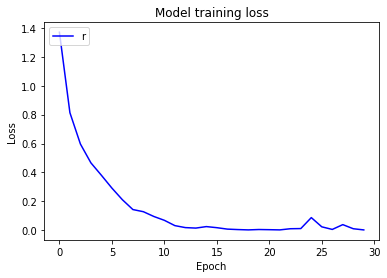

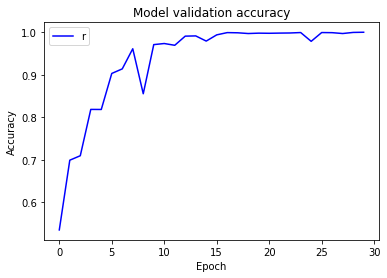

In [12]:
resnet_50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_50 = resnet_50.fit(
    ds_train,
    steps_per_epoch=int(train_size/BATCH_SIZE),
    validation_steps=int(test_size/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)
# train loss
plt.plot(history_50.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend('resnet_50', loc='upper left')
plt.show()
# val acc
plt.plot(history_50.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend('resnet_50', loc='upper left')
plt.show()

1. ResNet 34
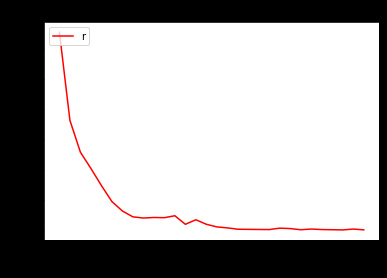
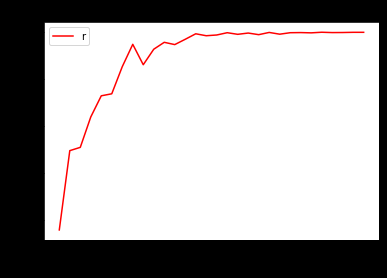
2. ResNet 50
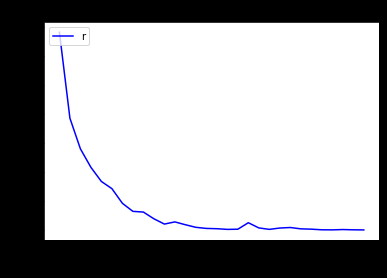
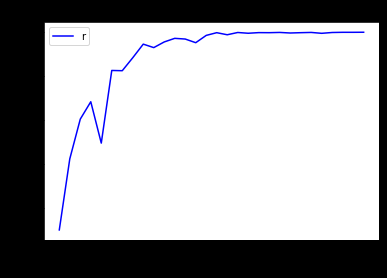
3. Plain 34
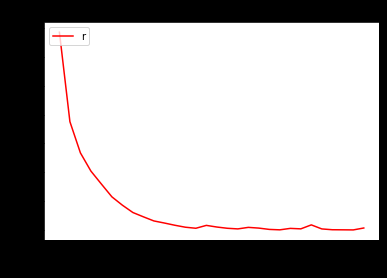
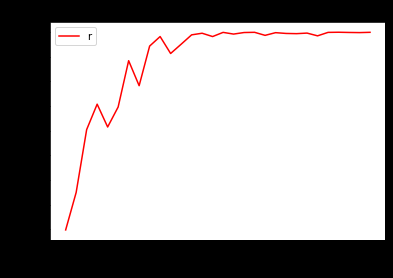
4. Plain 50
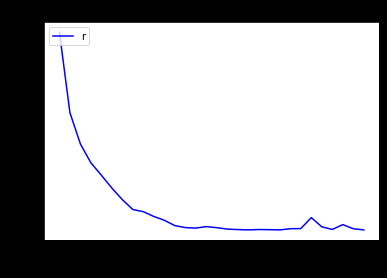
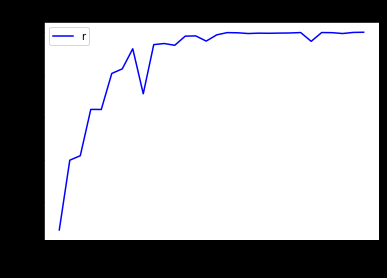

In [ ]:
# 회고
"""
에폭을 겁나게 돌렸다. 성공했지만 이게 무슨 의미가 있는지 잘 모르겠다.
"""